In [1]:
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import openai  
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
import openai  # Ensure you ha
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
from nltk.corpus import stopwords
from stop_words import get_stop_words
from hijri_converter import convert


openai.api_key='key_here'

/Users/azamatgudiev/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data = pd.read_csv('ingush_data.csv', index_col=0)

In [126]:
#data.status_violations.unique()

## Data pre-processing

In [127]:
#convert_column_format(data, 'status_violations')

In [129]:
# List of words to filter out
unwanted_words_0 = ['ОСАГО', 'ремней', 'пристегнут', 'Светопропускание']
unwanted_words_1 = get_stop_words('ru')
unwanted_words_2 = stopwords.words('russian')

#unwanted_words = unwanted_words_0+unwanted_words_1+unwanted_words_2
unwanted_words = unwanted_words_0
def process_text(text):
    # Split the text into sentences based on ', '
    sentences = text.split(', ')
    # Remove sentences that contain any of the unwanted words
    filtered_sentences = [sentence for sentence in sentences if all(word not in sentence for word in unwanted_words)]
    # Join the remaining sentences back together
    result_text = ', '.join(filtered_sentences)
    return result_text

# Apply the process_text function to each value in the 'status_violations' column
data['road_conditions'] = data['road_conditions'].apply(process_text)


In [114]:
data.status_violations[1]

"['Несоответствие скорости конкретным условиям движения', 'Эксплуатация ТС с техническими неисправностями, при которых запрещается их эксплуатация', 'Управление ТС лицом, не имеющим права на управление ТС'"

In [115]:
data.status_violations[1]

"['Несоответствие скорости конкретным условиям движения', 'Эксплуатация ТС с техническими неисправностями, при которых запрещается их эксплуатация', 'Управление ТС лицом, не имеющим права на управление ТС'"

In [143]:
prompts_dict = {
    'status_violations': f"""
        Based on an analysis of car accident data, we've identified clusters of keywords that describe violations by drivers that led to accidents.
        Here are the keywords for one such cluster: {{keyword_str}}. Your task is to name this cluster in a way that directly reflects these driver violations,
        using the keywords provided. Aim for a name that is concise and descriptive, suitable for a legend bar on a graph. For example, if the keywords are 'speeding, red-light running, aggressive',
        a good cluster name might be 'Speeding & Aggressive Driving Violations'. If the keywords frequently include 'Unknown', name the cluster 'Unknown Violations'.
        Remember, the cluster name must be in English and derived from the keywords given.
    """,

    'nearby': f"""
        Based on an analysis of car accident data, we've identified clusters of keywords that describe the surroundings or locations near which car accidents occurred.
        Here are the keywords for one such cluster: {{keyword_str}}. Your task is to name this cluster in a way that directly reflects these locations,
        using the keywords provided. Aim for a name that is concise and descriptive, suitable for a legend bar on a graph. For example, if the keywords are 'school, crosswalk, busy',
        a good cluster name might be 'School Vicinity & Busy Crosswalks'. If the keywords frequently include 'Unknown', name the cluster 'Unknown Locations'.
        Remember, the cluster name must be in English and derived from the keywords given.
    """,

    'road_conditions': f"""
        Based on an analysis of car accident data, we've identified clusters of keywords that describe road conditions at the time of these accidents.
        Here are the keywords for one such cluster: {{keyword_str}}. Your task is to name this cluster in a way that directly reflects these road conditions,
        using the keywords provided. Aim for a name that is concise and descriptive,
        suitable for a legend bar on a graph. For example, if the keywords are 'wet, slippery, rainy,'
        a good cluster name might be 'Wet & Slippery Conditions'. If the keywords frequently include 'Unknown',
        name the cluster 'Unknown Conditions'. Remember, the cluster name must be in English and derived from the keywords given.
    """,

    'participant_violations': f"""
        Based on an analysis of car accident data, we've identified clusters of keywords that describe violations made by pedestrians leading to car accidents.
        Here are the keywords for one such cluster: {{keyword_str}}. Your task is to name this cluster in a way that directly reflects these pedestrian violations,
        using the keywords provided. Aim for a name that is concise and descriptive, suitable for a legend bar on a graph. For example, if the keywords are 'jaywalking, ignoring, signals, distracted',
        a good cluster name might be 'Jaywalking & Distraction Violations'. If the keywords frequently include 'Unknown', name the cluster 'Unknown Violations'.
        Remember, the cluster name must be in English and derived from the keywords given.
    """
}


# Topic Modeling - Non-Negative Matrix Factorization (NMF)

Topic 1:


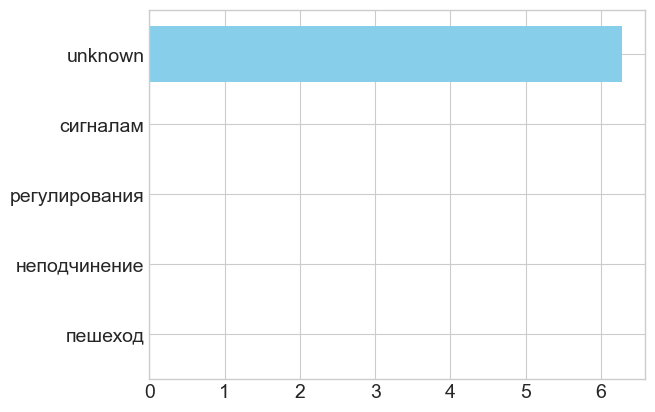

Topic 5:


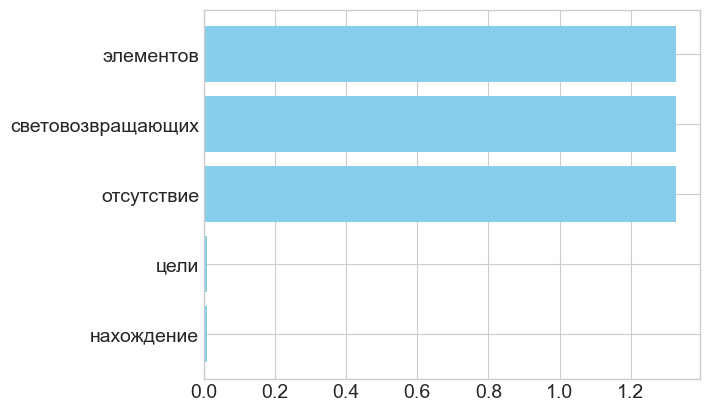

Topic 3:


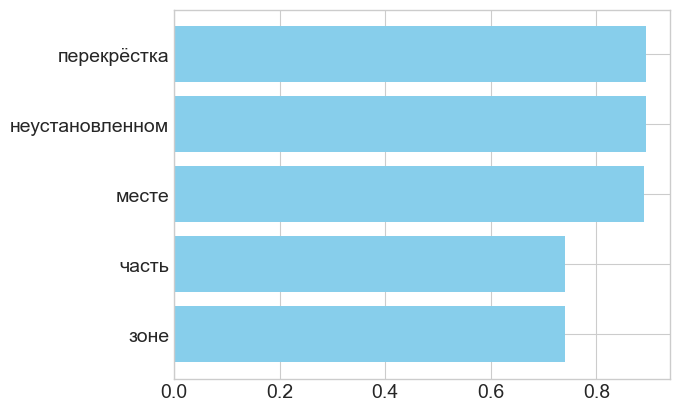

Topic 2:


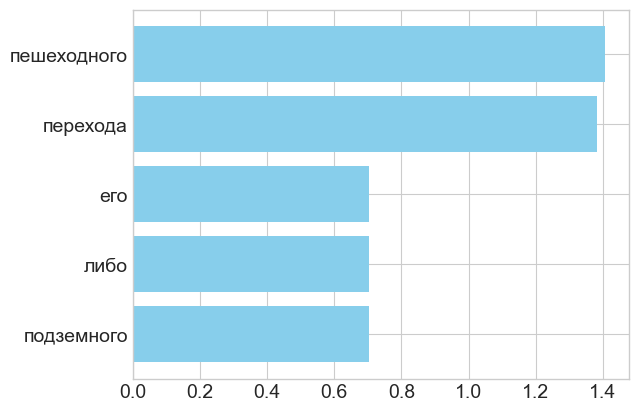

Topic 6:


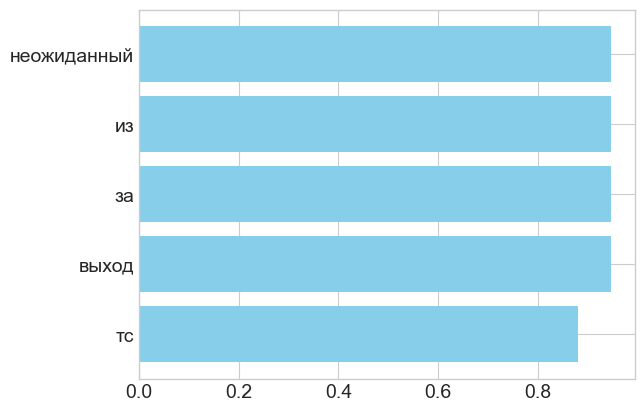

Topic 7:


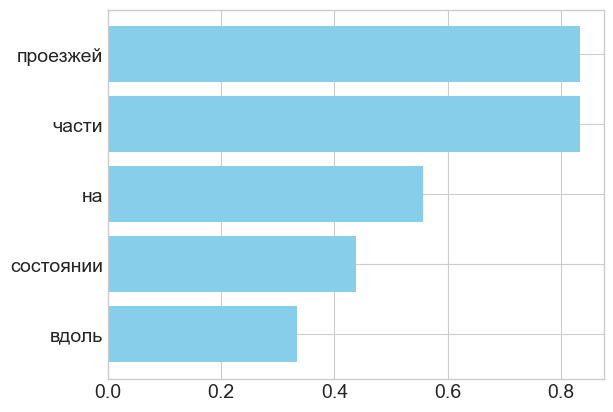

Topic 4:


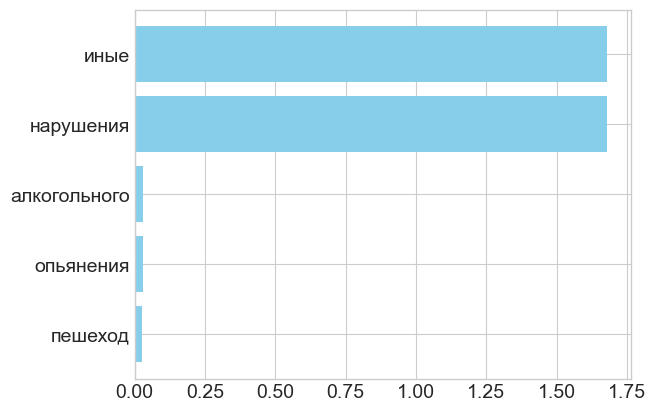

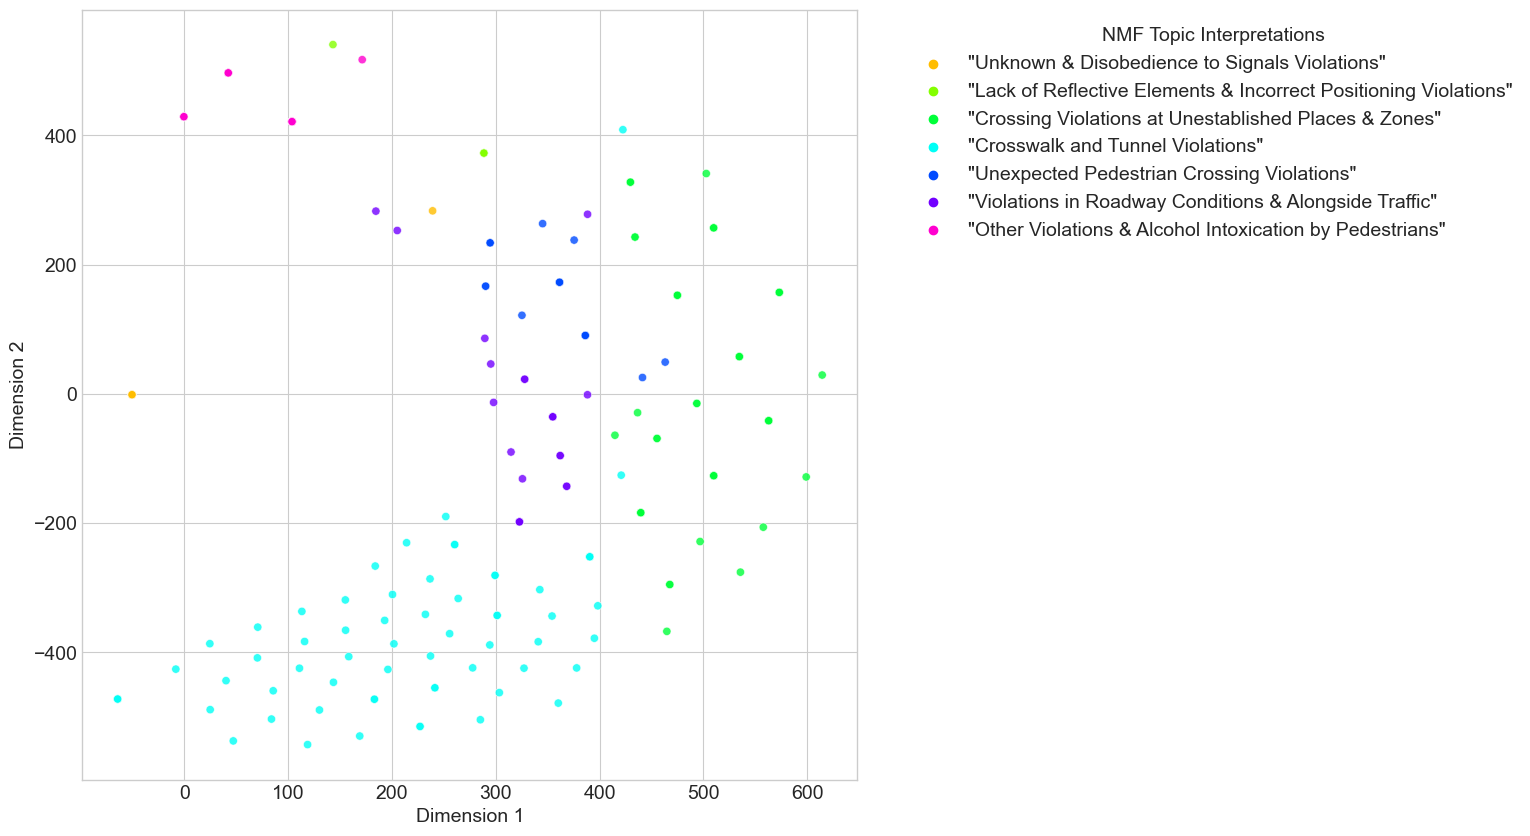

In [142]:
def display_barcharts(model, feature_names, no_top_words, order):
    for topic_idx in order:
        topic = model.components_[topic_idx]
        print(f"Topic {topic_idx + 1}:")
        top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        plt.figure()
        plt.barh(top_features, weights, color='skyblue')
        plt.gca().invert_yaxis()
        plt.show()

def is_valid_list(s):
    try:
        result = ast.literal_eval(s)
        return isinstance(result, list)
    except (ValueError, SyntaxError):
        return False

def convert_column_format(dataframe, column_name):
    dataframe = dataframe.copy()
    dataframe[column_name] = dataframe[column_name].fillna('["Unknown"]')
    if dataframe[column_name].dtype == object:
        dataframe[column_name] = dataframe[column_name].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) and is_valid_list(x) else x
        )
    dataframe[column_name] = dataframe[column_name].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
    return dataframe

def get_cluster_names(cluster_keywords, column_name):
    cluster_names = {}
    for cluster_num, keywords in cluster_keywords.items():
        keyword_str = ', '.join([word for word, count in keywords])
        prompt = prompts_dict.get(column_name, "").format(keyword_str=keyword_str)
        
        # Assuming an API call to ChatGPT or a similar method to get a response
        response = openai.ChatCompletion.create(
             model="gpt-4",
             messages=[{"role": "assistant", "content": prompt}]
         )
        # Extract just the cluster name from the response
        suggested_name = response['choices'][0]['message']['content'].strip()
        
        # Make sure the response is treated as a singular cluster name
        cluster_names[cluster_num] = suggested_name.split('\n')[0].strip()  # Taking the first line and stripping whitespace
    
    return cluster_names

def process_column(data, column_name, n_components=7, no_top_words=5):
    converted_data = convert_column_format(data, column_name)
    prefix = column_name
    
    vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf = vectorizer.fit_transform(converted_data[column_name].tolist())
    
    nmf = NMF(n_components=n_components, random_state=0)
    nmf.fit(tfidf)
    nmf_topics = nmf.transform(tfidf)
    
    nmf_topic_assignments = nmf_topics.argmax(axis=1)
    data[f'{prefix}_nmf_topic'] = nmf_topic_assignments
    
    def get_cluster_keywords(model, feature_names, no_top_words):
        cluster_keywords = {}
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
            top_features = [(feature_names[i], topic[i]) for i in top_features_ind]
            cluster_keywords[topic_idx] = top_features
        return cluster_keywords
    
    cluster_keywords = get_cluster_keywords(nmf, vectorizer.get_feature_names_out(), no_top_words)
    
    cluster_names = get_cluster_names(cluster_keywords, column_name)
    name_to_index = {name: index for index, name in enumerate(cluster_names.values())}
    
    data[f'{prefix}_nmf_topic_interpretation'] = data[f'{prefix}_nmf_topic'].map(cluster_names)
    
    svd = TruncatedSVD(n_components=50, random_state=42)
    reduced_tfidf_matrix = svd.fit_transform(tfidf)
    
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(reduced_tfidf_matrix)
    
    tsne_df = pd.DataFrame(data={
        'Dimension 1': tsne_results[:, 0],
        'Dimension 2': tsne_results[:, 1],
        f'{prefix}_label_name': data[f'{prefix}_nmf_topic_interpretation']
    })
    
    topic_order = tsne_df[f'{prefix}_label_name'].unique()
    topic_order_indices = [name_to_index[topic] for topic in topic_order]
    
    display_barcharts(nmf, vectorizer.get_feature_names_out(), no_top_words, topic_order_indices)
    
    plt.figure(figsize=(10, 10))
    sns.scatterplot(
        x='Dimension 1',
        y='Dimension 2',
        hue=f'{prefix}_label_name',
        palette=sns.color_palette("hsv", len(set(tsne_df[f'{prefix}_label_name']))),
        data=tsne_df,
        legend="full",
        alpha=0.8
    )
    
    plt.legend(title='NMF Topic Interpretations', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    def save_topic_info(model, feature_names, no_top_words, filename):
        topic_info = []
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]
            topic_info.append(pd.DataFrame({'Feature': top_features, f'Topic {topic_idx + 1} Weight': weights}))
        topic_info_df = pd.concat(topic_info, axis=1)
        topic_info_df.to_excel(filename, index=False)
    
    save_topic_info(nmf, vectorizer.get_feature_names_out(), no_top_words, 'Topic_Modeling.xlsx')
    
    return data

processed_data = process_column(data, 'participant_violations') 


Topic 1:


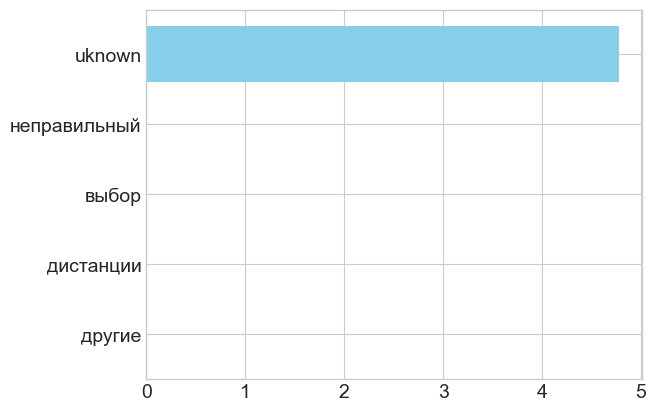

Topic 3:


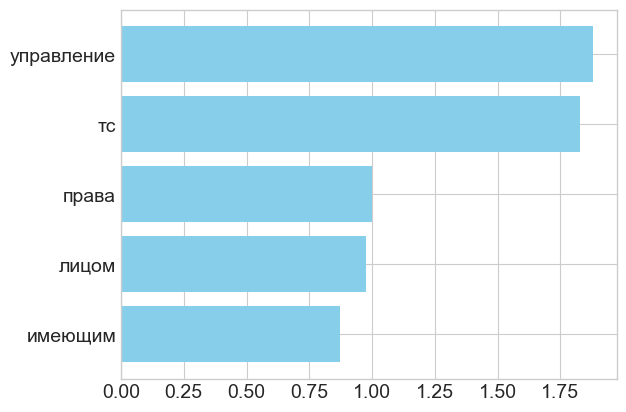

Topic 2:


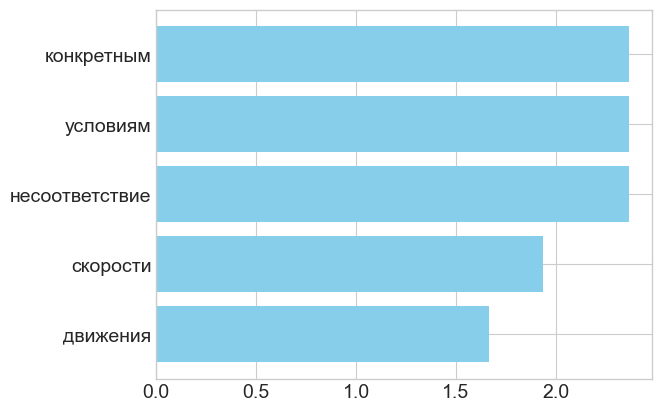

Topic 7:


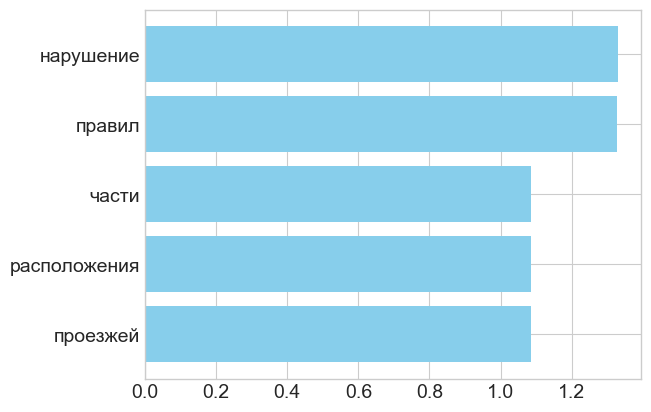

Topic 5:


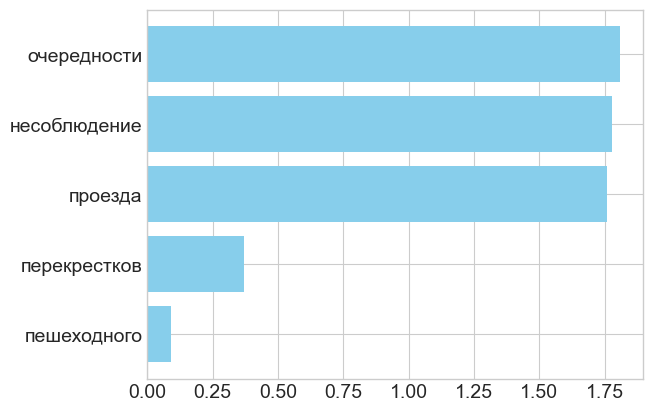

Topic 6:


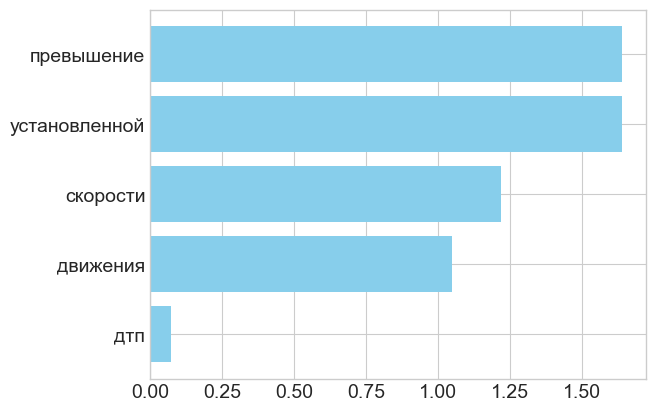

Topic 4:


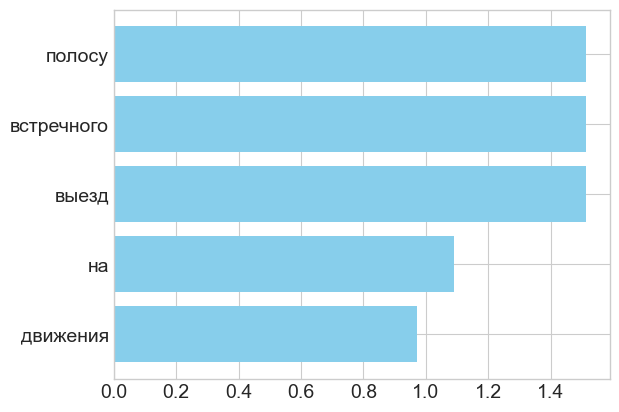

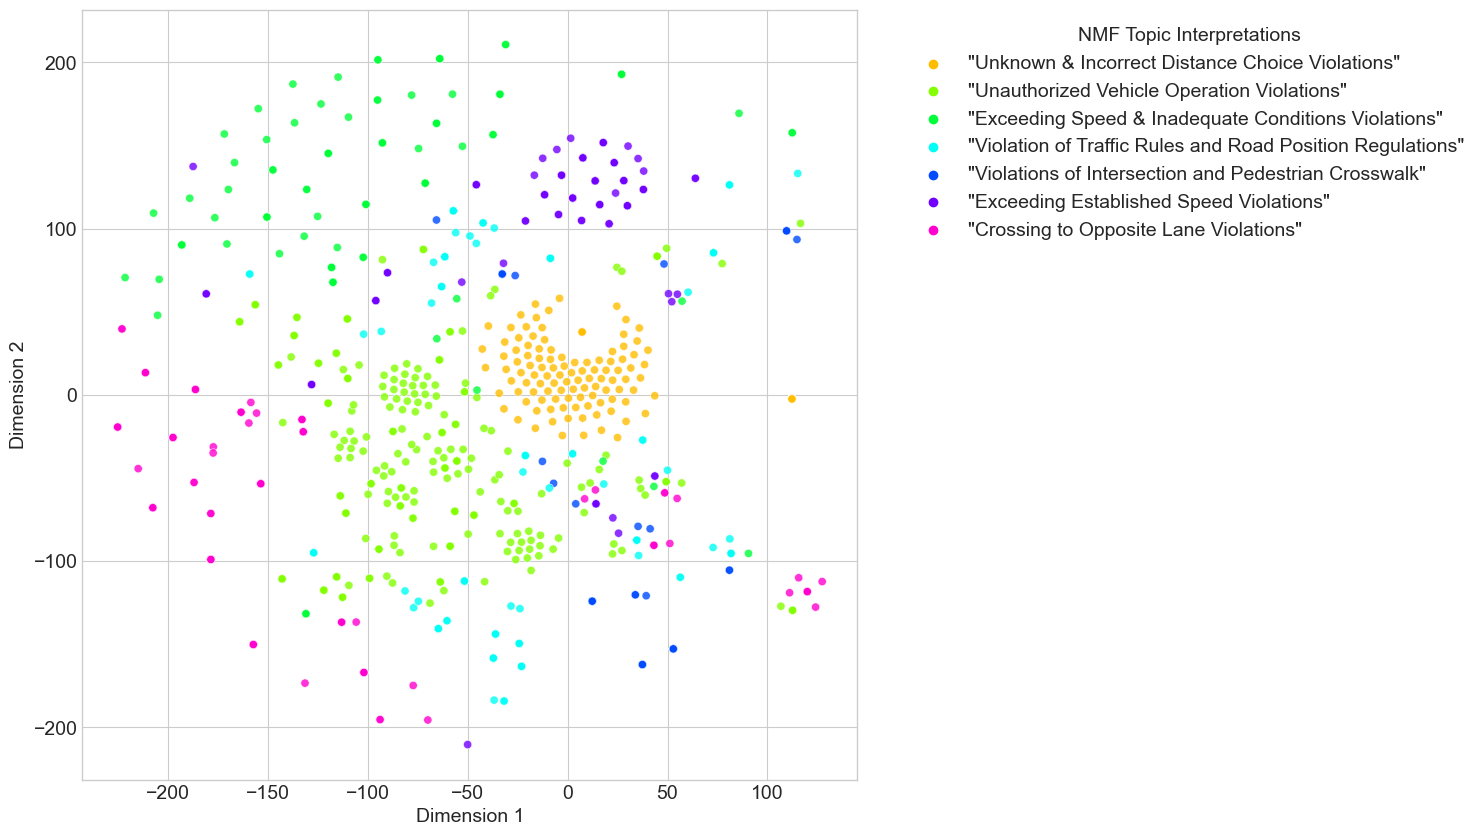

Topic 1:


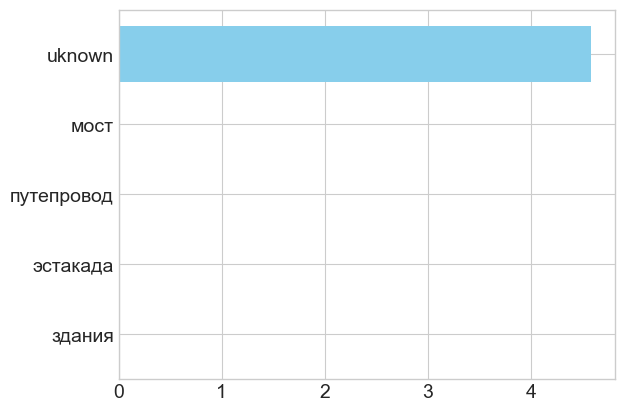

Topic 7:


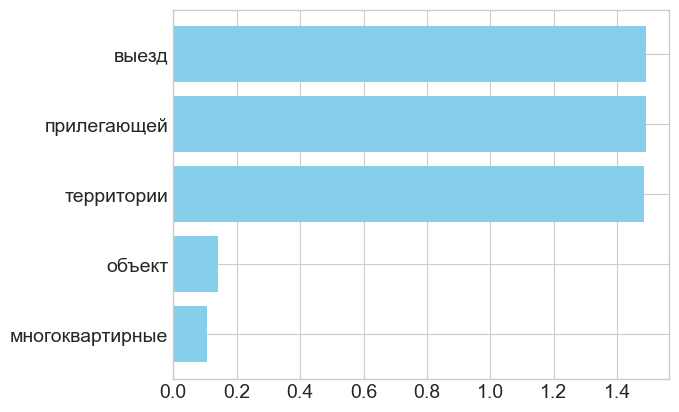

Topic 4:


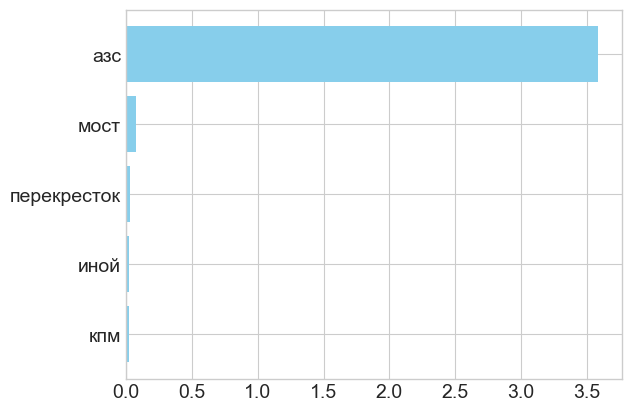

Topic 2:


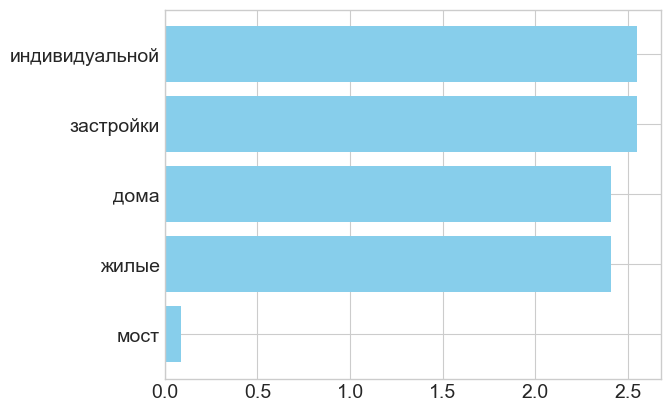

Topic 5:


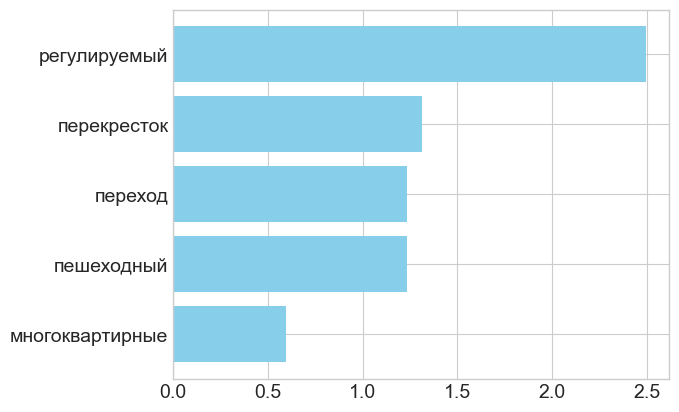

Topic 6:


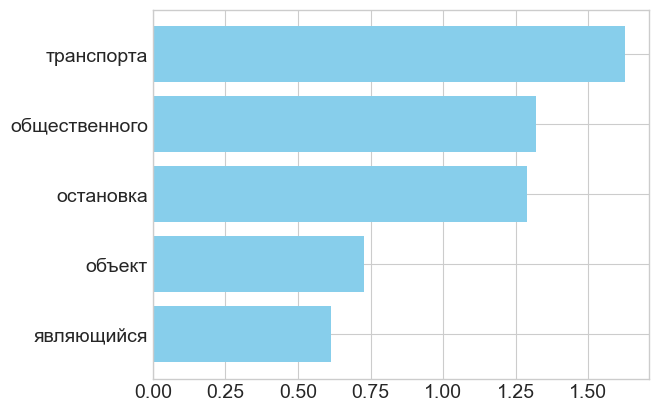

Topic 3:


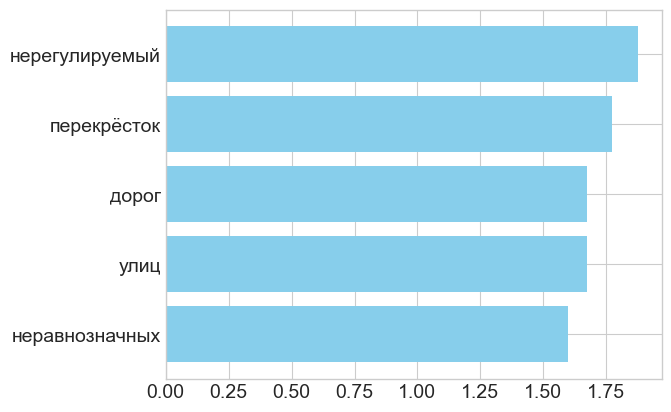

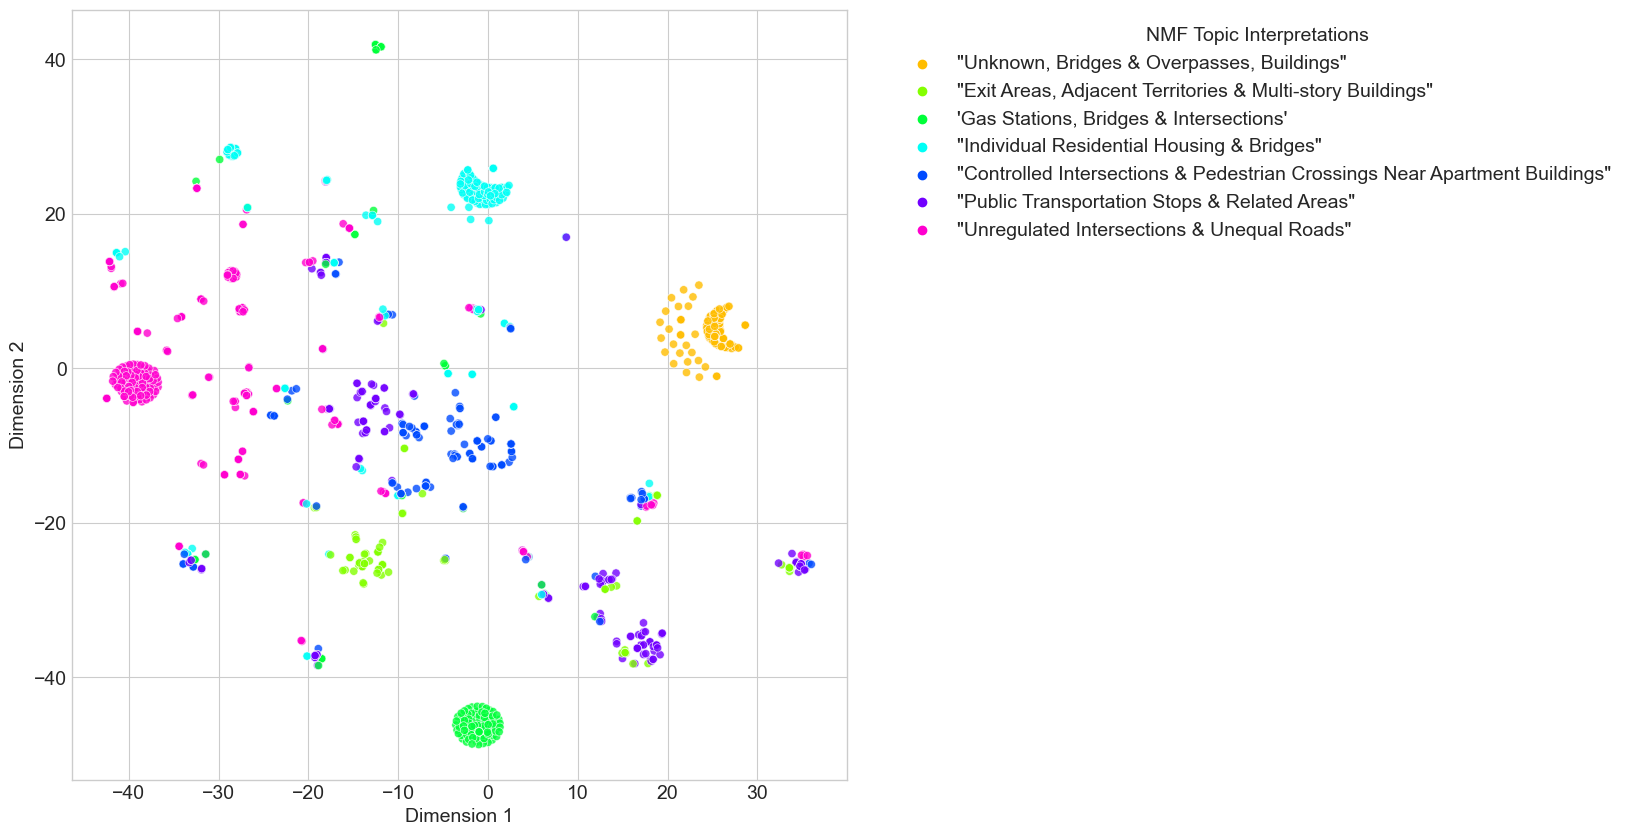

Topic 1:


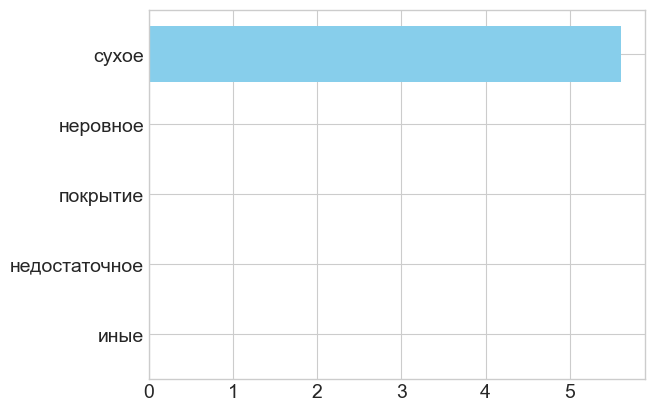

Topic 4:


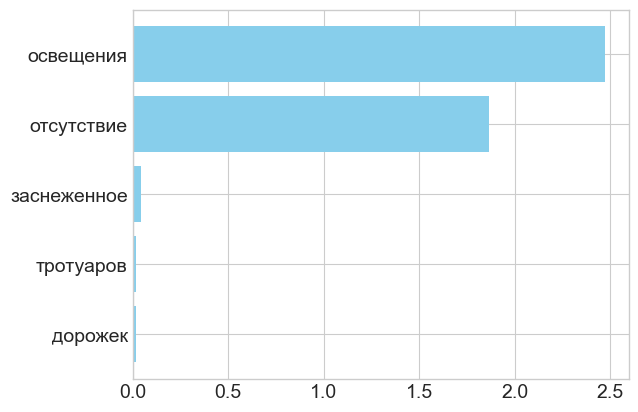

Topic 5:


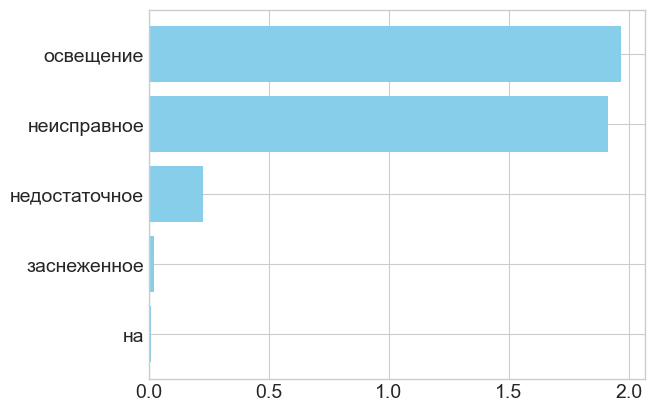

Topic 6:


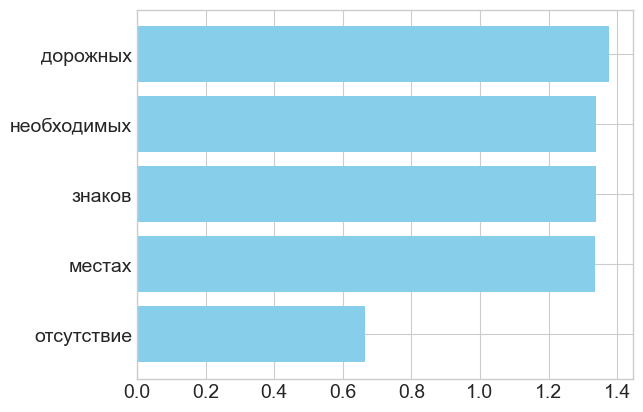

Topic 3:


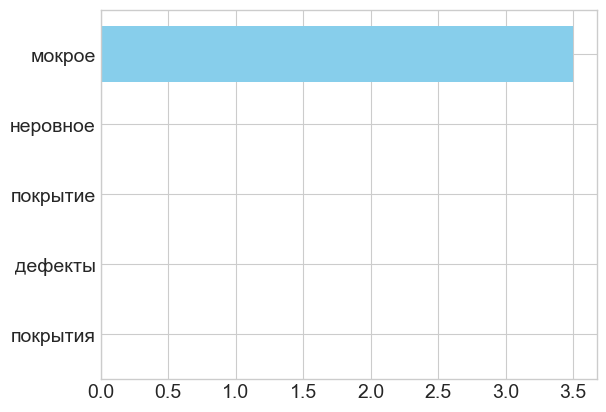

Topic 2:


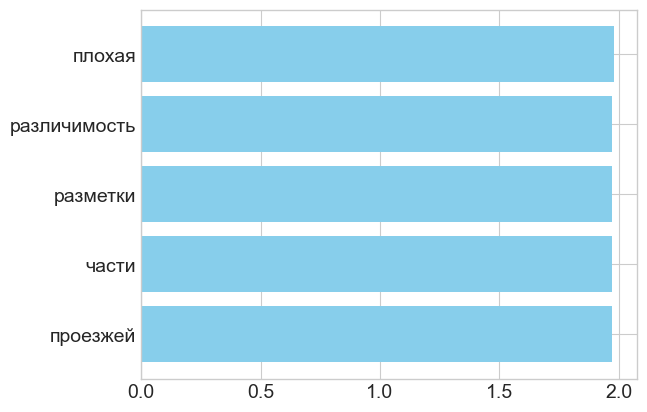

Topic 7:


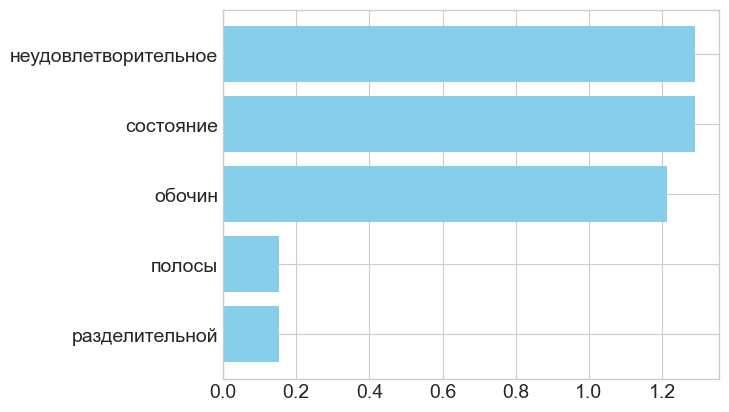

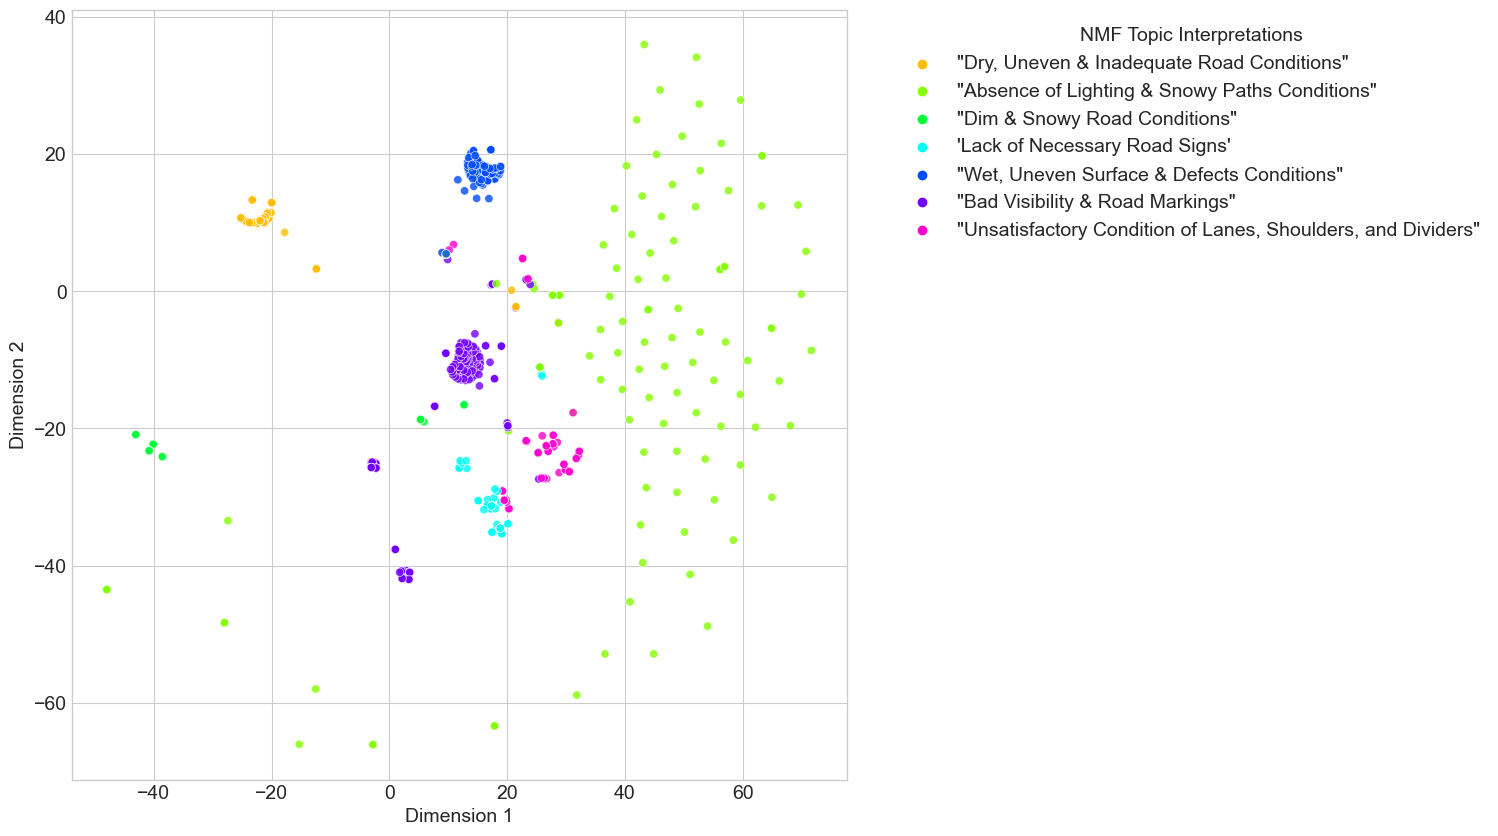

Topic 1:


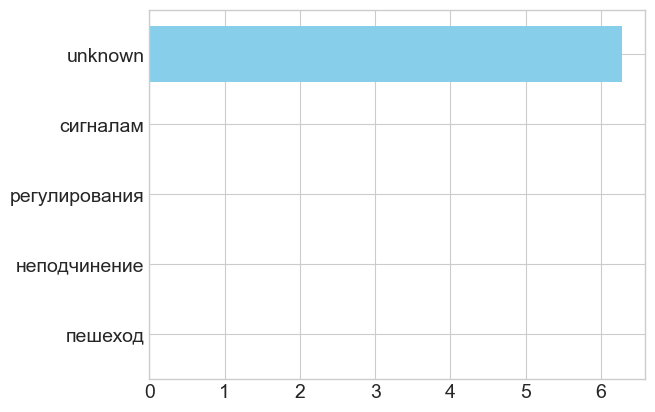

Topic 5:


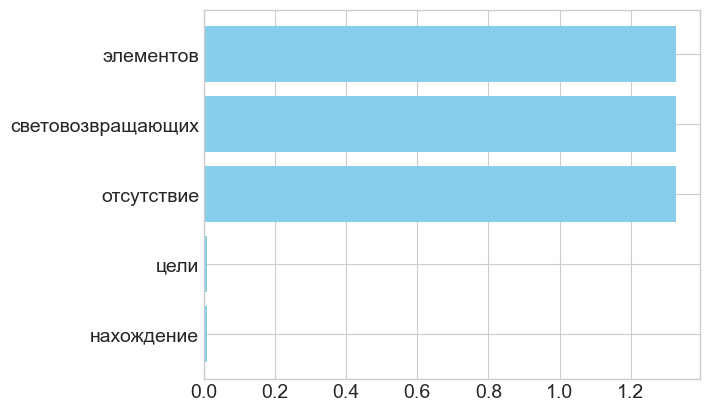

Topic 3:


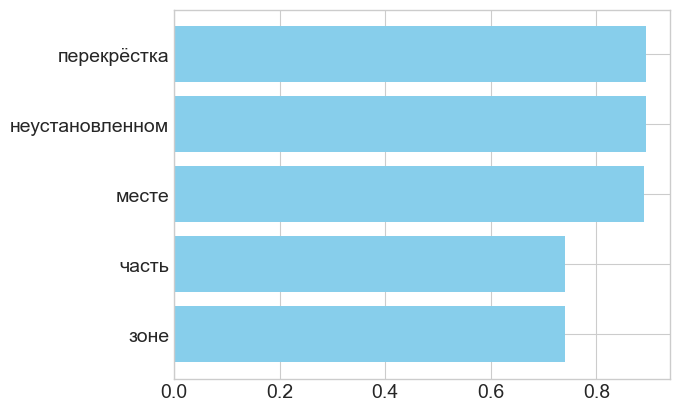

Topic 2:


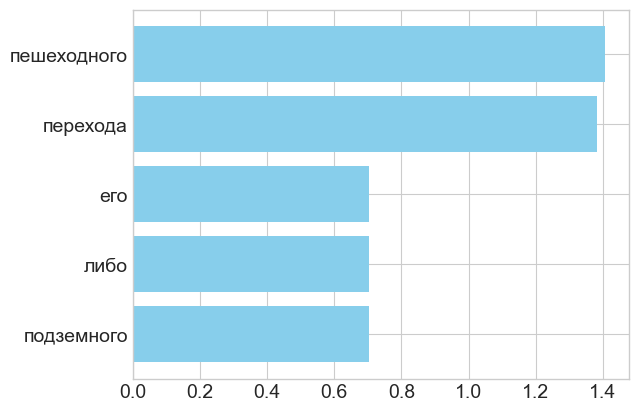

Topic 6:


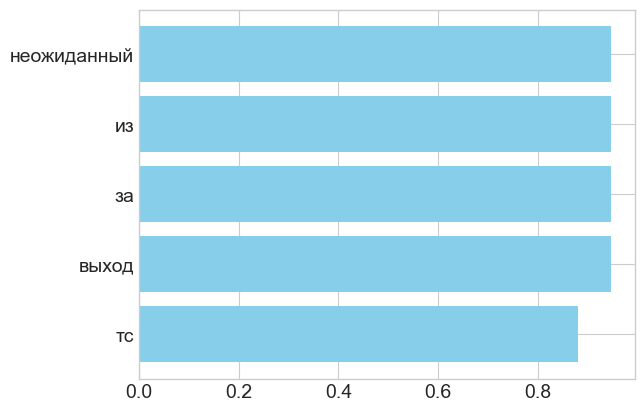

Topic 7:


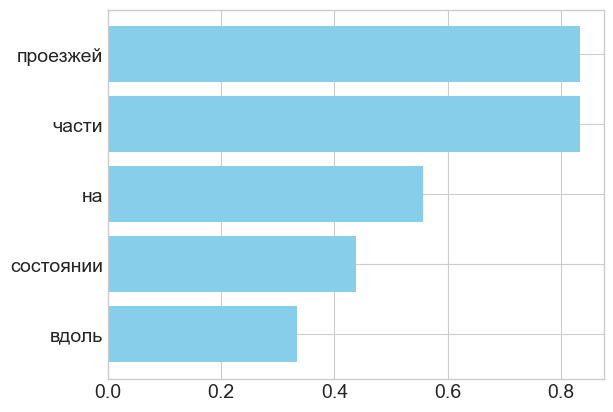

Topic 4:


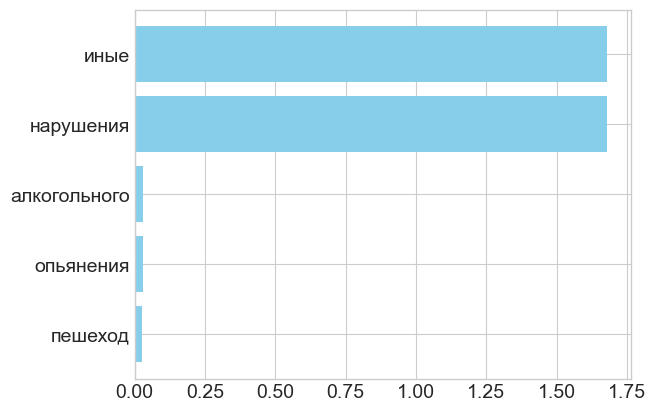

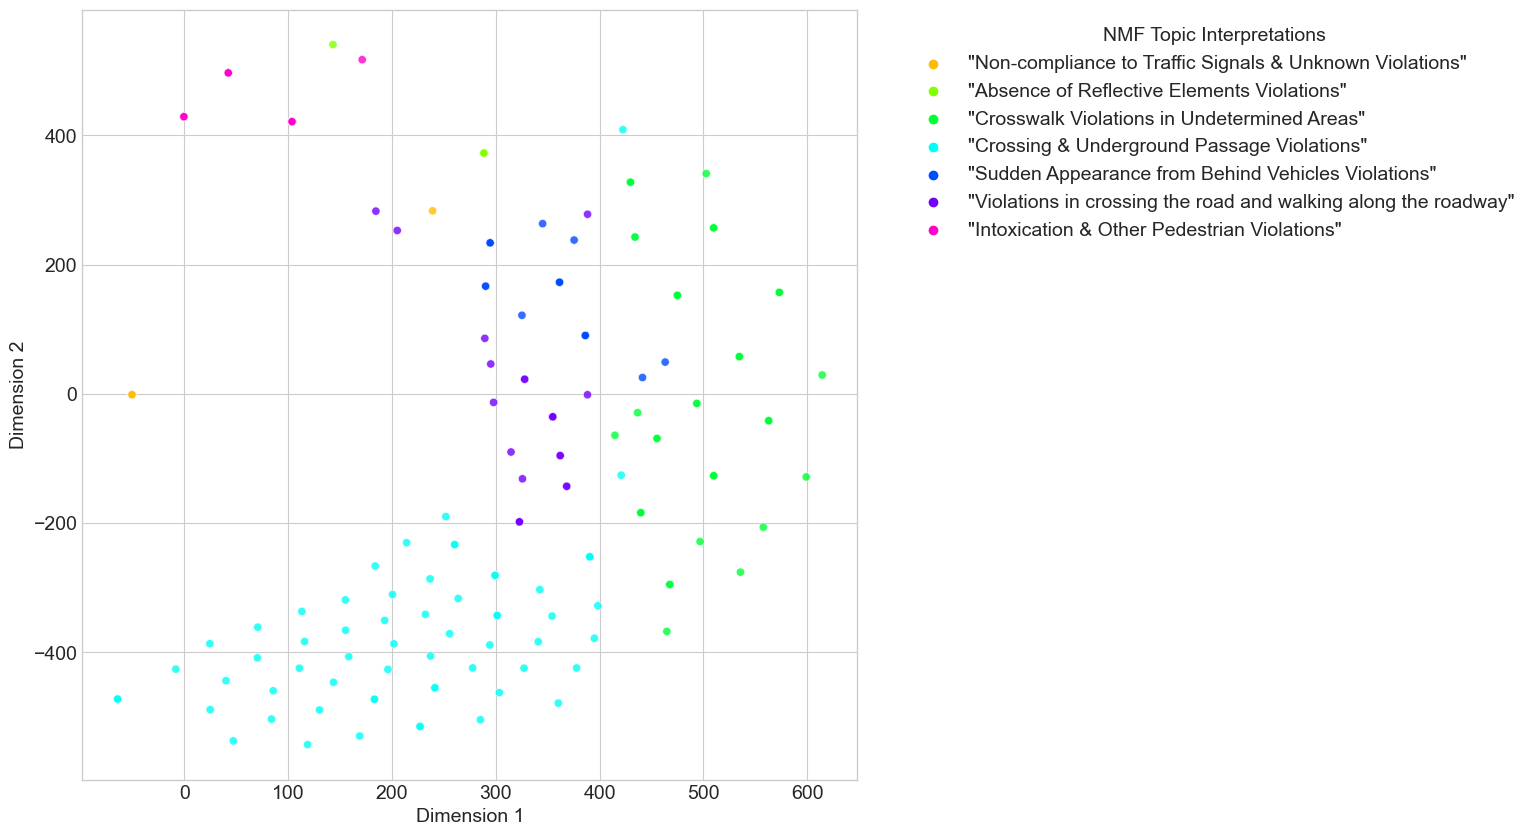

In [145]:
process_list = ['status_violations', 'nearby', 'road_conditions', 'participant_violations']

for i in data[process_list]:
    processed_data = process_column(data, i) 


# Hierarchical Clustering with Neural Networks

/var/folders/fl/374pqpm17q5fl8r9c1vws6wh0000gn/T/ipykernel_94344/1004809582.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')  # Updated


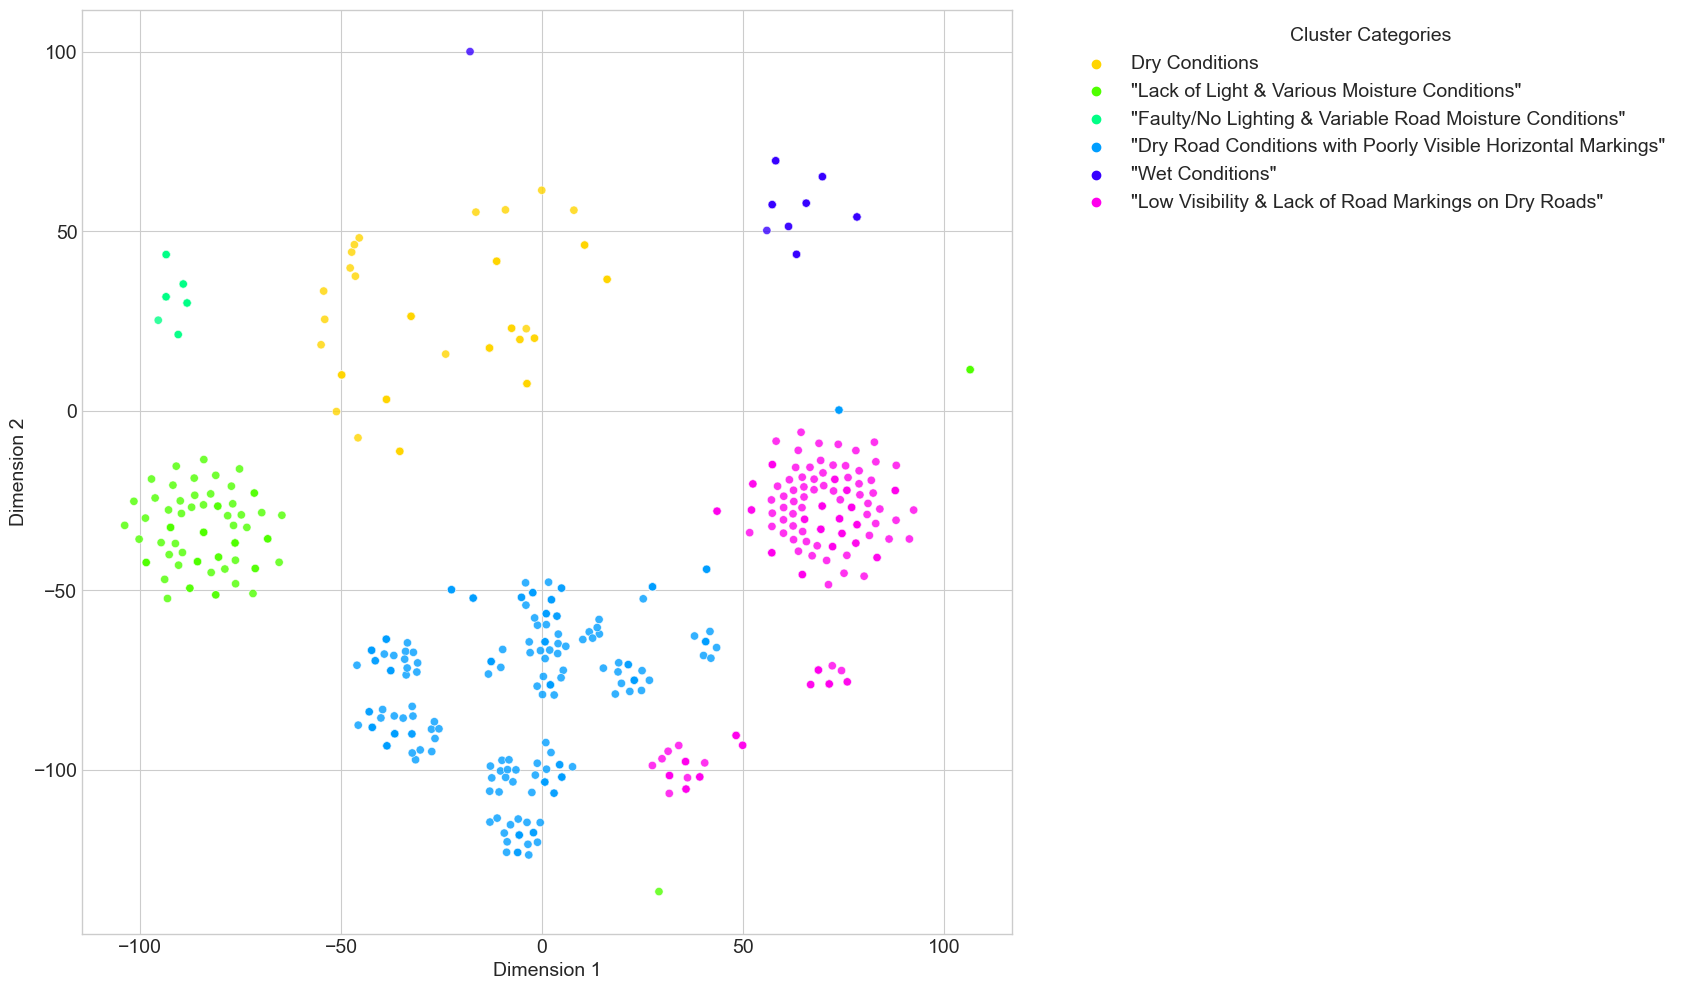

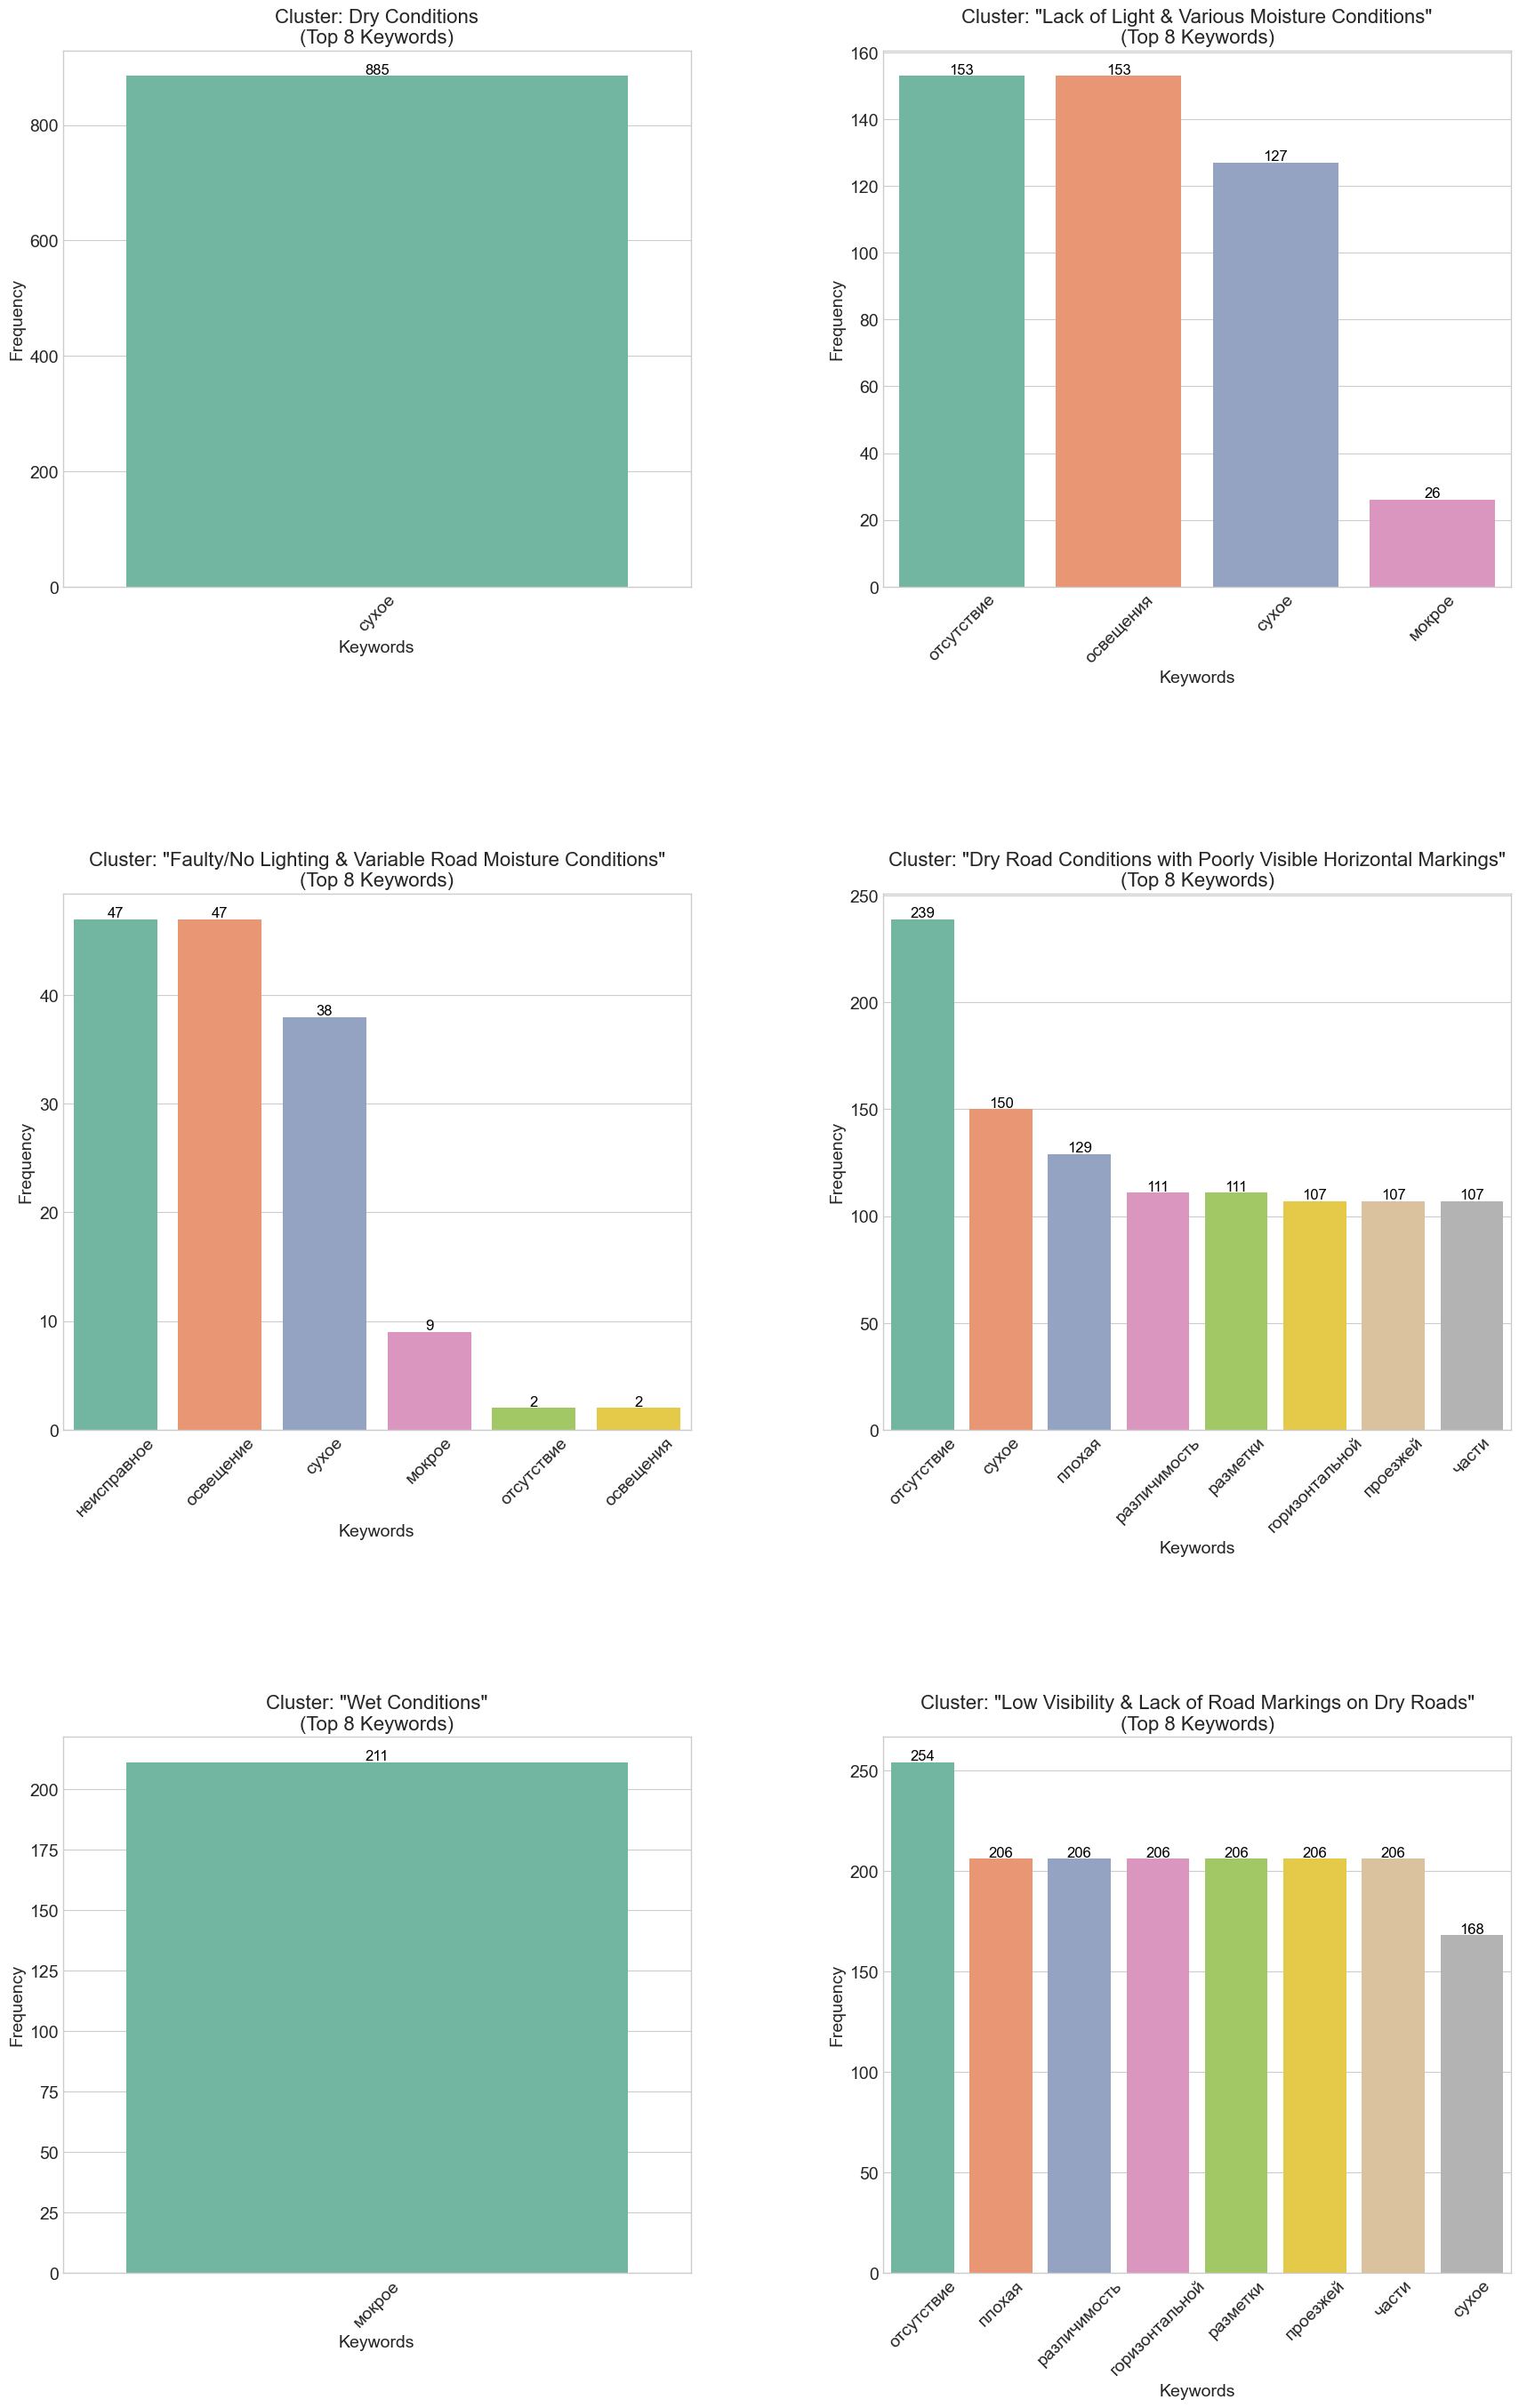

In [135]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = ''.join([char for char in text if char not in string.punctuation and not char.isdigit()])
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    return text
def get_cluster_names(cluster_keywords, column_name):
    cluster_names = {}
    for cluster_num, keywords in cluster_keywords.items():
        keyword_str = ', '.join([word for word, count in keywords])
        prompt = prompts_dict.get(column_name, "").format(keyword_str=keyword_str)
        
        # Assuming an API call to ChatGPT or a similar method to get a response
        response = openai.ChatCompletion.create(
             model="gpt-4",
             messages=[{"role": "assistant", "content": prompt}]
         )
        # Extract just the cluster name from the response
        suggested_name = response['choices'][0]['message']['content'].strip()
        
        # Make sure the response is treated as a singular cluster name
        cluster_names[cluster_num] = suggested_name.split('\n')[0].strip()  # Taking the first line and stripping whitespace
    
    return cluster_names

def process_and_visualize(data, column, n_clusters=6, n_pca_components=12, random_state=42, top_n_words=8):
    data[column].fillna("Unknown", inplace=True)
    prefix = column
    plt.style.use('seaborn-whitegrid')  # Updated
    plt.rcParams.update({'font.size': 14})  # Updated
    # Step 1: Transform the text data to a TF-IDF matrix
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(data[column])

    # Step 2: Perform PCA for dimensionality reduction
    pca = PCA(n_components=n_pca_components, random_state=random_state)
    reduced_tfidf_matrix = pca.fit_transform(tfidf_matrix.toarray())

    # Step 3: Apply Agglomerative Clustering to the reduced data
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels = agg_clustering.fit_predict(reduced_tfidf_matrix)

    # Step 4: Add labels to data
    data[f'{prefix}_agg_labels'] = agg_labels  # Prefix the column name

    # Step 5: Analyze the clusters
    # Preprocess the text data
    data[f'processed_{prefix}'] = data[column].apply(preprocess_text)  # Prefix the column name
    grouped = data.groupby(f'{prefix}_agg_labels')  # Prefix the column name
    cluster_keywords = {}
    for name, group in grouped:
        text_data = ' '.join(group[f'processed_{prefix}'])  # Prefix the column name
        word_counts = Counter(text_data.split())
        common_words = word_counts.most_common(top_n_words)
        cluster_keywords[name] = common_words
    
    # Step 6: Get meaningful cluster category names
    cluster_categories = get_cluster_names(cluster_keywords, column)  # pass column name to get_cluster_names
    data[f'{prefix}_cluster_categories'] = data[f'{prefix}_agg_labels'].map(cluster_categories)  # Prefix the column name

    
    # Step 7: Visualize the clusters using t-SNE
    tsne = TSNE(n_components=2, random_state=random_state)
    tsne_results = tsne.fit_transform(reduced_tfidf_matrix)
    tsne_df = pd.DataFrame(data={
        'Dimension 1': tsne_results[:, 0],
        'Dimension 2': tsne_results[:, 1],
        f'{prefix}_label_name': data[f'{prefix}_cluster_categories']  # Prefix the column name
    })
    
    # Plotting
    plt.figure(figsize=(12, 12))
    sns.scatterplot(
        x='Dimension 1',
        y='Dimension 2',
        hue=f'{prefix}_label_name',
        palette=sns.color_palette("hsv", len(set(tsne_df[f'{prefix}_label_name']))),
        data=tsne_df,
        legend="full",
        alpha=0.8
    )
    hue_order = tsne_df[f'{prefix}_label_name'].unique()

    plt.legend(title='Cluster Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    # Step 8: plot 
    n_cols = 2
    n_rows = int(-(-n_clusters // n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 10))
    axs = axs.ravel()

    for idx, cluster_category in enumerate(hue_order):
        cluster_num = [num for num, name in cluster_categories.items() if name == cluster_category][0]
        keywords = cluster_keywords[cluster_num]
        words, counts = zip(*keywords)
        color_palette = sns.color_palette("Set2", n_colors=top_n_words)  # Updated
        bar_plot = sns.barplot(x=list(words), y=list(counts), ax=axs[idx], palette=color_palette)  # Updated
        axs[idx].set_title(f'Cluster: {cluster_category}\n(Top {top_n_words} Keywords)', fontsize=16)  # Updated
        axs[idx].set_xlabel('Keywords', fontsize=14)  # Updated
        axs[idx].set_ylabel('Frequency', fontsize=14)  # Updated
        axs[idx].tick_params(axis='x', rotation=45)  # Updated

        for p in bar_plot.patches:  # Updated
            bar_plot.annotate(f'{int(p.get_height())}',
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              fontsize=12, color='black',
                              xytext=(0, 5),
                              textcoords='offset points')  # Updated

    # Remove any unused subplots
    for i in range(n_clusters, n_rows * n_cols):
        fig.delaxes(axs[i])

    plt.tight_layout(pad=8.0)  # Updated
    fig.savefig('cluster_keywords.png', dpi=300)  # Updated
    plt.show()
    
    def save_cluster_info(cluster_keywords, filename):
        cluster_info = []
        for cluster_num, keywords in cluster_keywords.items():
            words, counts = zip(*keywords)
            cluster_info.append(pd.DataFrame({
                'Keyword': words, 
                f'Cluster {cluster_num + 1} Frequency': counts
            }))
        # Concatenate DataFrames and save to Excel
        cluster_info_df = pd.concat(cluster_info, axis=1)
        cluster_info_df.to_excel(filename, index=False)
    
    save_cluster_info(cluster_keywords, 'Hierarchical_Clustering.xlsx')
    
    return data


# Usage:
updated_data = process_and_visualize(data, 'road_conditions')


In [3]:
process_list = ['status_violations', 'nearby', 'road_conditions', 'participant_violations']

for i in data[process_list]:
    updated_data = process_and_visualize(data, i) 


NameError: name 'process_and_visualize' is not defined

In [5]:
data.columns

Index(['id', 'tags', 'light', 'point', 'nearby', 'region', 'scheme', 'address',
       'weather', 'category', 'datetime', 'severity', 'dead_count',
       'injured_count', 'parent_region', 'road_conditions',
       'participants_count', 'participant_categories', 'geometry',
       'participant_role', 'participant_gender', 'participant_violations',
       'participant_health_status', 'vehicle_year', 'vehicle_brand',
       'vehicle_color', 'vehicle_model', 'vehicle_category', 'status_role',
       'status_gender', 'status_violations', 'status_health_status',
       'status_years_of_driving_experience'],
      dtype='object')

In [6]:
data=data.drop(['status_violations_agg_labels',
       'processed_status_violations',
       'participant_violations_nmf_topic',
       'participant_violations_nmf_topic_interpretation',
       'participant_violations_agg_labels', 'processed_participant_violations', 'nearby_nmf_topic',
       'nearby_nmf_topic_interpretation', 'nearby_agg_labels',
       'processed_nearby',
       'road_conditions_nmf_topic', 'road_conditions_nmf_topic_interpretation',
       'road_conditions_agg_labels', 'processed_road_conditions', 'road_conditions', 'nearby',
          'status_violations', 'participant_violations'], axis=1)

KeyError: "['status_violations_agg_labels', 'processed_status_violations', 'participant_violations_nmf_topic', 'participant_violations_nmf_topic_interpretation', 'participant_violations_agg_labels', 'processed_participant_violations', 'nearby_nmf_topic', 'nearby_nmf_topic_interpretation', 'nearby_agg_labels', 'processed_nearby', 'road_conditions_nmf_topic', 'road_conditions_nmf_topic_interpretation', 'road_conditions_agg_labels', 'processed_road_conditions'] not found in axis"

In [1667]:
data.to_csv('final_clustered.csv')

# Feature engineering

In [54]:
data = pd.read_csv('ingush_data.csv', index_col=0)

### function to convert the string representation of a list to a list, and then join the elements of the list into a string.

In [55]:
def convert_column_format(dataframe, column_name):
    # Replace missing values with 'Unknown'
    dataframe[column_name] = dataframe[column_name].fillna('Unknown')
    if dataframe[column_name].dtype == object:
        # Try to convert string representation of list to list
        dataframe[column_name] = dataframe[column_name].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    # Join list to string if the column contains lists
    dataframe[column_name] = dataframe[column_name].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
    return   # Modify this line to return the updated dataframe


### category column

In [56]:
values_to_replace = ['Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы',
                     'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ',
                     'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность',
                     'Иной вид ДТП']

In [57]:
data['category'] = data['category'].replace(values_to_replace, 'Наезд на пешехода')

### date_time column

In [58]:
data['datetime'].value_counts()

datetime
2022-09-09 19:35:00    2
2022-11-22 17:20:00    2
2021-05-15 22:40:00    1
2016-08-11 16:20:00    1
2017-12-24 19:45:00    1
                      ..
2023-03-11 17:10:00    1
2023-03-12 10:50:00    1
2023-03-17 17:30:00    1
2023-04-01 18:10:00    1
2018-03-12 21:50:00    1
Name: count, Length: 1737, dtype: int64

In [59]:
# Convert the 'datetime_column' to a pandas datetime object
data['datetime'] = pd.to_datetime(data['datetime'])

# Extract the season, month, and day of the week
data['season'] = data['datetime'].dt.quarter
season_mapping = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
data['season'] = data['season'].map(season_mapping)

data['month'] = data['datetime'].dt.month
data['day_of_week'] = data['datetime'].dt.day_name()

# Determine whether it's morning, day, evening, or night
data['time_of_day'] = data['datetime'].apply(lambda x: 'morning' if 5 <= x.hour < 12
                                                    else 'day' if 12 <= x.hour < 17
                                                    else 'evening' if 17 <= x.hour < 21
                                                    else 'night')

In [60]:
# Define a function to convert a Gregorian date to Hijri
def to_hijri(date):
    gregorian_date = pd.to_datetime(date).date()  # Convert string to datetime object and then to date
    hijri_date = convert.Gregorian(gregorian_date.year, gregorian_date.month, gregorian_date.day).to_hijri()
    return f'{hijri_date.year}-{hijri_date.month:02d}-{hijri_date.day:02d}'

# Apply the function to the 'datetime' column to create a new column 'hijri'
data['hijri'] = data['datetime'].apply(to_hijri)


In [61]:
# Create a dictionary to map Hijri month numbers to names
hijri_month_names = {
    1: 'Muharram',
    2: 'Safar',
    3: 'Rabi Al-Awwal',
    4: 'Rabi Al-Thani',
    5: 'Jumada Al-Awwal',
    6: 'Jumada Al-Thani',
    7: 'Rajab',
    8: 'Sha\'ban',
    9: 'Ramadan',
    10: 'Shawwal',
    11: 'Dhu Al-Qa\'dah',
    12: 'Dhu Al-Hijjah'
}

# Define a function to extract the Hijri month number and return the Hijri month name
def get_hijri_month(hijri_date_str):
    hijri_month_number = int(hijri_date_str.split('-')[1])
    return hijri_month_names[hijri_month_number]

# Apply the function to the 'hijri' column to create a new column 'hijri_month_name'
data['hijri_month_name'] = data['hijri'].apply(get_hijri_month)

In [62]:
# Create a new column 'in_first_three_days_of_shawwal' to store the results
data['in_first_three_days_of_shawwal'] = data['hijri'].apply(lambda x: 1 if x[-5:] in ('10-01', '10-02', '10-03') else 0)


### participant_categories

In [63]:
convert_column_format(data,'participant_categories' )

In [64]:
data['participant_categories'].value_counts()

participant_categories
Все участники                                    1246
Все участники, Пешеходы                           251
Все участники, Дети                               109
Все участники, Пешеходы, Дети                      96
Все участники, Мотоциклисты                        10
Все участники, Велосипедисты                        8
Все участники, Велосипедисты, Дети                  7
Все участники, Общ. транспорт                       4
Все участники, Мотоциклисты, Дети                   2
Все участники, Пешеходы, Общ. транспорт             2
Дети, Пешеходы, Все участники                       1
Дети, Все участники                                 1
Все участники, Общ. транспорт, Дети                 1
Все участники, Пешеходы, Общ. транспорт, Дети       1
Name: count, dtype: int64

In [65]:
participant_mapping = {
    'Все участники': 'Автомобиль',
    'Все участники, Пешеходы': 'Пешеходы',
    'Все участники, Дети': 'Дети',
    'Все участники, Пешеходы, Дети': 'Дети',
    'Все участники, Мотоциклисты': 'Двухколесный транспорт',
    'Все участники, Велосипедисты': 'Двухколесный транспорт',
    'Все участники, Велосипедисты, Дети': 'Дети',
    'Все участники, Общ. транспорт': 'Общ. транспорт',
    'Все участники, Мотоциклисты, Дети': 'Дети',
    'Все участники, Пешеходы, Общ. транспорт': 'Пешеходы',
    'Дети, Пешеходы, Все участники': 'Дети',
    'Дети, Все участники': 'Дети',
    'Все участники, Общ. транспорт, Дети': 'Дети',
    'Все участники, Пешеходы, Общ. транспорт, Дети': 'Дети'
}

data['participant_categories'] = data['participant_categories'].replace(participant_mapping)


In [66]:
data['participant_categories'].value_counts()

participant_categories
Автомобиль                1246
Пешеходы                   253
Дети                       218
Двухколесный транспорт      18
Общ. транспорт               4
Name: count, dtype: int64

### participant_health_status

In [67]:
data['participant_health_status'] = data['participant_health_status'].apply(lambda x: 'Скончался' if 'скончался' in str(x).lower() else x)


In [68]:
data['participant_health_status']=data['participant_health_status'].apply(lambda x: 'Не пострадал' if 'Получил травмы с оказанием разовой медицинской помощи, к категории раненый не относится' in str(x) else x)


In [69]:
data['participant_health_status']=data['participant_health_status'].apply(lambda x: 'Не пострадал' if 'Получил травмы с оказанием разовой медицинской помощи, к категории раненый не относится' in str(x) else x)


In [70]:
data['participant_health_status'] = data['participant_health_status'].apply(lambda x: 'Стационарный раненый' if 'Раненый, находящийся (находившийся) на стационарном лечении' in str(x) else x)


In [71]:
data['participant_health_status'] = data['participant_health_status'].apply(lambda x: 'Амбулаторный раненый' if 'Раненый, находящийся (находившийся)  на амбулаторном лечении' in str(x) else x)


In [72]:
data['participant_health_status'] = data['participant_health_status'].apply(lambda x: 'Амбулаторный раненый' if 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара' in str(x) else x)


In [73]:
data['participant_health_status'] = data['participant_health_status'].apply(lambda x: 'Амбулаторный раненый' if 'Получил телесные повреждения с показанием к лечению в медицинских организациях (кроме разовой медицинской помощи)' in str(x) else x)


In [74]:
data['participant_health_status'].value_counts()

participant_health_status
Стационарный раненый    170
Скончался               106
Амбулаторный раненый     75
Не пострадал              3
Name: count, dtype: int64

### vehicle_year_bin

In [75]:
# Define bins and labels for equal-width binning
bins_equal_width = list(range(1975, 2026, 5))  # 1975-1979, 1980-1984, ...
labels_equal_width = [f'{i}-{i+4}' for i in bins_equal_width[:-1]]

# Apply equal-width binning
data['vehicle_year_bin_eq_width'] = pd.cut(
    data['vehicle_year'], 
    bins=bins_equal_width, 
    labels=labels_equal_width, 
    include_lowest=True,
    right=False  # This ensures that the binning is left-inclusive
)
data['vehicle_year_bin_eq_width'] = data['vehicle_year_bin_eq_width'].cat.add_categories('Unknown').fillna('Unknown')

In [76]:
data['vehicle_year_bin_eq_width'].value_counts()

vehicle_year_bin_eq_width
2005-2009    495
2010-2014    466
2000-2004    387
1995-1999    136
2015-2019    130
1990-1994     44
Unknown       42
1985-1989     19
2020-2024     12
1980-1984      6
1975-1979      2
Name: count, dtype: int64

### vehicle_brand vehicle_model

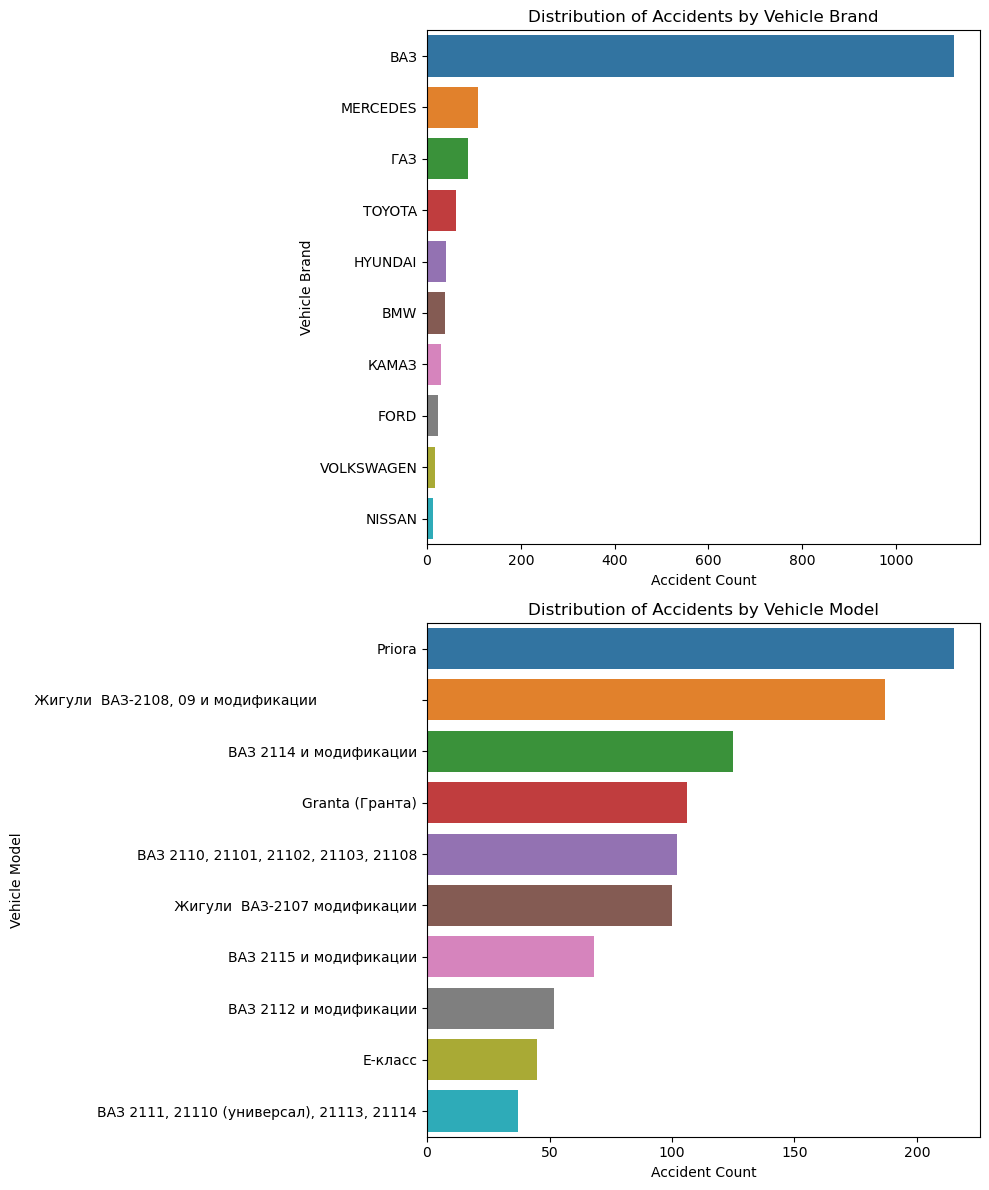

In [77]:
# Grouping data by 'vehicle_brand' and 'vehicle_model' to get the total count of accidents per brand and model
grouped_brand = data.groupby('vehicle_brand').size().reset_index(name='accident_count')
grouped_model = data.groupby('vehicle_model').size().reset_index(name='accident_count')

# Sorting the grouped data in descending order of accident count for better visualization
grouped_brand_sorted = grouped_brand.sort_values(by='accident_count', ascending=False).head(10)  # Top 10 brands
grouped_model_sorted = grouped_model.sort_values(by='accident_count', ascending=False).head(10)  # Top 10 models

# Plotting the distribution of accidents by 'vehicle_brand' and 'vehicle_model'
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Bar chart for 'vehicle_brand'
sns.barplot(data=grouped_brand_sorted, x='accident_count', y='vehicle_brand', ax=axs[0])
axs[0].set_title('Distribution of Accidents by Vehicle Brand')
axs[0].set_xlabel('Accident Count')
axs[0].set_ylabel('Vehicle Brand')

# Bar chart for 'vehicle_model'
sns.barplot(data=grouped_model_sorted, x='accident_count', y='vehicle_model', ax=axs[1])
axs[1].set_title('Distribution of Accidents by Vehicle Model')
axs[1].set_xlabel('Accident Count')
axs[1].set_ylabel('Vehicle Model')

plt.tight_layout()
plt.show()


### vehicle_category

In [78]:
data.vehicle_category.value_counts()

vehicle_category
В-класс (малый) до 3,9 м                                                                 718
С-класс (малый средний, компактный) до 4,3 м                                             530
Легковые автомобили (без типа)                                                            98
Прочие легковые автомобили                                                                76
D-класс (средний) до 4,6 м                                                                75
Фургоны                                                                                   30
Минивэны и универсалы повышенной вместимости                                              28
Седельные тягачи                                                                          17
Самосвалы                                                                                 14
Шасси                                                                                     13
Прочие одноярусные                                   

In [79]:
# Defining the replacement dictionary based on the provided Russian vehicle categories
replacement_dict_russian = {
    'В-класс (малый) до 3,9 м': 'B — маленькие автомобили',
    'С-класс (малый средний, компактный) до 4,3 м': 'C — среднеразмерные автомобили',
    'Легковые автомобили (без типа)': 'B — маленькие автомобили',
    'Прочие легковые автомобили': 'B — маленькие автомобили',
    'D-класс (средний) до 4,6 м': 'D — полноразмерные автомобили',
    'Фургоны': 'M — минивэны и коммерческие автомобили',
    'Минивэны и универсалы повышенной вместимости': 'M — минивэны и коммерческие автомобили',
    'Е-класс (высший средний, бизнес-класс) до 4,9 м': 'E — автомобили бизнес-класса',
    'А-класс (особо малый) до 3,5 м': 'A — мини-автомобили',
    'S-класс (высший, представительский класс) более 4,9 м': 'S — спортивные купе',
    'Седельные тягачи': 'M — минивэны и коммерческие автомобили',
    'Самосвалы': 'M — минивэны и коммерческие автомобили',
    'Шасси': 'M — минивэны и коммерческие автомобили',
    'Прочие одноярусные': 'M — минивэны и коммерческие автомобили',
    'Бортовые грузовые автомобили': 'M — минивэны и коммерческие автомобили',
    'Одноэтажные длиной не более 5 м': 'M — минивэны и коммерческие автомобили',
    'Одноэтажные длиной от 5 до 8 м': 'M — минивэны и коммерческие автомобили',
    'Прочие грузовые автомобили': 'M — минивэны и коммерческие автомобили',
    'Автобусы (без типа)': 'M — минивэны и коммерческие автомобили',
    'Тракторы': 'M — минивэны и коммерческие автомобили',
    'Грузовые автомобили (без типа)': 'M — минивэны и коммерческие автомобили',
    'Цистерны': 'M — минивэны и коммерческие автомобили',
    'Транспортные средства оперативно-служебные для перевозки лиц, находящихся под стражей': 'M — минивэны и коммерческие автомобили',
    'Одноэтажные длиной от 8 до 12 м': 'M — минивэны и коммерческие автомобили',
    'Прочая спецтехника': 'M — минивэны и коммерческие автомобили',
    'Мопеды с двигателем внутреннего сгорания менее 50 см. куб.': 'A — мини-автомобили',
    'Бортовые': 'M — минивэны и коммерческие автомобили',
    'Школьные автобусы': 'M — минивэны и коммерческие автомобили',
    'Мотоциклы': 'A — мини-автомобили',
    'Автокраны и транспортные средства, оснащенные кранами-манипуляторами': 'M — минивэны и коммерческие автомобили',
    'Транспортные средства для перевозки нефтепродуктов': 'M — минивэны и коммерческие автомобили',
    'Иные ТС': 'M — минивэны и коммерческие автомобили',
    'Автобетоносмесители': 'M — минивэны и коммерческие автомобили',
    'Специализированная техника военного назначения': 'M — минивэны и коммерческие автомобили',
    'Автоэвакуаторы': 'M — минивэны и коммерческие автомобили',
    'Автомобили скорой медицинской помощи': 'M — минивэны и коммерческие автомобили',
    'Рефрижераторы': 'M — минивэны и коммерческие автомобили',
    'Пожарные автомобили': 'M — минивэны и коммерческие автомобили',
    'Боевая техника': 'M — минивэны и коммерческие автомобили',
    'Мопеды с двигателем внутреннего сгорания более 50 см. куб.': 'A — мини-автомобили',
    'Транспортные средства, оснащенные подъемниками с рабочими платформами': 'M — минивэны и коммерческие автомобили',
    'Экскаваторы': 'M — минивэны и коммерческие автомобили'
}


# Replacing the values in the 'vehicle_category' column according to the new mapping
data['vehicle_category'] = data['vehicle_category'].replace(replacement_dict_russian)

In [80]:
data['vehicle_category'].value_counts()

vehicle_category
B — маленькие автомобили                  892
C — среднеразмерные автомобили            530
M — минивэны и коммерческие автомобили    197
D — полноразмерные автомобили              75
A — мини-автомобили                        14
E — автомобили бизнес-класса               11
S — спортивные купе                         7
Велосипеды                                  4
Name: count, dtype: int64

The category "M — минивэны и коммерческие автомобили" (M — Minivans and Commercial Vehicles) from the dataset includes the following types of vehicles based on the given mapping:

Фургоны (Vans)
Минивэны и универсалы повышенной вместимости (Minivans and high-capacity station wagons)
Седельные тягачи (Tractor units)
Самосвалы (Dump trucks)
Шасси (Chassis)
Прочие одноярусные (Other single-deck vehicles)
Бортовые грузовые автомобили (Sideboard trucks)
Прочие грузовые автомобили (Other trucks)
Автобусы (без типа) (Buses (unspecified type))
Тракторы (Tractors)
Грузовые автомобили (без типа) (Trucks (unspecified type))
Цистерны (Tankers)
Транспортные средства оперативно-служебные для перевозки лиц, находящихся под стражей (Operational vehicles for transporting detained individuals)
Одноэтажные длиной от 8 до 12 м (Single-deck vehicles with a length of 8 to 12 meters)
Прочая спецтехника (Other specialized equipment)
Бортовые (Sideboards)
Школьные автобусы (School buses)
Автокраны и транспортные средства, оснащенные кранами-манипуляторами (Crane trucks and vehicles equipped with crane manipulators)
Транспортные средства для перевозки нефтепродуктов (Vehicles for transporting petroleum products)
Иные ТС (Other vehicles)
Автобетоносмесители (Concrete mixers)
Специализированная техника военного назначения (Specialized military equipment)
Автоэвакуаторы (Tow trucks)
Автомобили скорой медицинской помощи (Ambulances)
Рефрижераторы (Refrigerated trucks)
Пожарные автомобили (Fire trucks)
Транспортные средства, оснащенные подъемниками с рабочими платформами (Vehicles equipped with lifts with working platforms)
Экскаваторы (Excavators)




### status_health_status

In [81]:
data.status_health_status = data.status_health_status.fillna('Uknown')

data['status_health_status'] = data['status_health_status'].apply(lambda x: 'Скончался' if 'скончался' in str(x).lower() else x)


data['status_health_status']=data['status_health_status'].apply(lambda x: 'Не пострадал' if 'Получил травмы с оказанием разовой медицинской помощи, к категории раненый не относится' in str(x) else x)


data['status_health_status']=data['status_health_status'].apply(lambda x: 'Не пострадал' if 'Получил травмы с оказанием разовой медицинской помощи, к категории раненый не относится' in str(x) else x)


data['status_health_status'] = data['status_health_status'].apply(lambda x: 'Стационарный раненый' if 'Раненый, находящийся (находившийся) на стационарном лечении' in str(x) else x)


data['status_health_status'] = data['status_health_status'].apply(lambda x: 'Амбулаторный раненый' if 'Раненый, находящийся (находившийся)  на амбулаторном лечении' in str(x) else x)


data['status_health_status'] = data['status_health_status'].apply(lambda x: 'Амбулаторный раненый' if 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара' in str(x) else x)


data['status_health_status'] = data['status_health_status'].apply(lambda x: 'Амбулаторный раненый' if 'Получил телесные повреждения с показанием к лечению в медицинских организациях (кроме разовой медицинской помощи)' in str(x) else x)

data['status_health_status'] = data['status_health_status'].apply(lambda x: 'Не пострадал' if 'Получил телесные повреждения с показанием к лечению в медицинских организациях, фактически лечение не проходил, к категории раненый не относится' in str(x) else x)


In [82]:
data.status_health_status.value_counts()

status_health_status
Не пострадал            694
Стационарный раненый    520
Амбулаторный раненый    315
Скончался               194
Uknown                   16
Name: count, dtype: int64

### tags

In [83]:
convert_column_format(data, 'tags')

In [84]:
data['tags'].value_counts()

tags
Дорожно-транспортные происшествия                                                                                                                                                      1518
Дорожно-транспортные происшествия, ДТП и пострадавшие дети в возрасте до 16 лет                                                                                                         216
Дорожно-транспортные происшествия, ДТП и пострадавшие пешеходы, из-за наезда на пешеходов, на пешеходных переходах, по вине пешеходов                                                     3
Дорожно-транспортные происшествия, ДТП и пострадавшие пешеходы, из-за наезда на пешеходов, на пешеходных переходах, по вине пешеходов, ДТП и пострадавшие дети в возрасте до 16 лет       2
Name: count, dtype: int64

In [85]:
data['tags'] = data['tags'].apply(lambda x: 'ДТП с Детьми' if 'Дорожно-транспортные происшествия, ДТП и пострадавшие дети в возрасте до 16 лет' in str(x) else x)

data['tags'] = data['tags'].apply(lambda x: 'ДТП с Детьми' if 'Дорожно-транспортные происшествия, ДТП и пострадавшие пешеходы, из-за наезда на пешеходов, на пешеходных переходах, по вине пешеходов, ДТП и пострадавшие дети в возрасте до 16 лет' in str(x) else x)

data['tags'] = data['tags'].apply(lambda x: 'ДТП' if 'Дорожно-транспортные происшествия, ДТП и пострадавшие пешеходы, из-за наезда на пешеходов, на пешеходных переходах, по вине пешеходов' in str(x) else x)

data['tags'] = data['tags'].apply(lambda x: 'ДТП' if 'Дорожно-транспортные происшествия' in str(x) else x)


In [86]:
data['tags'].value_counts()

tags
ДТП             1521
ДТП с Детьми     218
Name: count, dtype: int64

### Light and Time of Day

In [87]:
# Convert the series to a DataFrame and reset the index
count_df = data[['light', 'time_of_day']].value_counts().reset_index()

# Rename the columns
count_df.columns = ['Light Condition', 'Time of Day', 'Count']

In [88]:
data.light.value_counts()

light
Светлое время суток                            822
В темное время суток, освещение отсутствует    423
В темное время суток, освещение включено       367
В темное время суток, освещение не включено     79
Сумерки                                         48
Name: count, dtype: int64

In [89]:
data['light'] = data['light'].apply(lambda x: 'В темное время суток, без освещения' if 'В темное время суток, освещение отсутствует' in str(x) else x)

data['light'] = data['light'].apply(lambda x: 'В темное время суток, без освещения' if 'В темное время суток, освещение не включено' in str(x) else x)


In [90]:
data.light.value_counts()

light
Светлое время суток                         822
В темное время суток, без освещения         502
В темное время суток, освещение включено    367
Сумерки                                      48
Name: count, dtype: int64

### Weather

In [91]:
convert_column_format(data, 'weather')

In [92]:
data.weather.value_counts()

weather
Ясно               1313
Пасмурно            229
Дождь               120
Туман                42
Снегопад             28
Пасмурно, Туман       3
Пасмурно, Дождь       2
Дождь, Туман          1
Дождь, Снегопад       1
Name: count, dtype: int64

In [93]:
data['weather'] = data['weather'].apply(lambda x: 'Снегопад' if 'Дождь, Снегопад' in str(x) else x)

data['weather'] = data['weather'].apply(lambda x: 'Туман' if 'Пасмурно, Туман' in str(x) else x)

data['weather'] = data['weather'].apply(lambda x: 'Дождь' if 'Пасмурно, Дождь' in str(x) else x)

data['weather'] = data['weather'].apply(lambda x: 'Туман' if 'Дождь, Туман' in str(x) else x)


In [94]:
data.weather.value_counts()

weather
Ясно        1313
Пасмурно     229
Дождь        122
Туман         46
Снегопад      29
Name: count, dtype: int64

### participant_role

In [95]:
data['participant_role'].value_counts()

participant_role
Пешеход                                                                                                                             340
Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира     11
Водитель                                                                                                                              2
Пассажир                                                                                                                              1
Name: count, dtype: int64

In [96]:
data['participant_role'] = data['participant_role'].apply(lambda x: 'Пешеход' if 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира' in str(x) else x)


In [97]:
data['participant_role'].value_counts()

participant_role
Пешеход     351
Водитель      2
Пассажир      1
Name: count, dtype: int64

### rename column names

In [98]:
rename_dict = {
    'participant_role': 'victim_role',
    'participant_gender': 'victim_gender',
    'participant_violations': 'victim_violations',
    'participant_health_status': 'victim_health_status',
    'participant_categories': 'victim_categories',
    'participants_count': 'victim_counts'
}

# Renaming the columns
data.rename(columns=rename_dict, inplace=True)


In [99]:
columns_to_rename = [
    'status_role',
    'status_gender',
    'status_violations',
    'status_health_status',
    'status_years_of_driving_experience'
]

# Generating the renaming dictionary dynamically
rename_dict = {col: col.replace('status', 'guilty') for col in columns_to_rename}

# Renaming the columns
data.rename(columns=rename_dict, inplace=True)

In [100]:
rename_dict = {
    'participant_violations_cluster_categories': 'victim_violations_cluster_categories',
    'status_violations_cluster_categories': 'guilty_violations_cluster_categories',
    'guilty_health_guilty': 'guilty_health_status'
}

# Renaming the columns
data.rename(columns=rename_dict, inplace=True)

In [101]:
data.columns

Index(['id', 'tags', 'light', 'point', 'nearby', 'region', 'scheme', 'address',
       'weather', 'category', 'datetime', 'severity', 'dead_count',
       'injured_count', 'parent_region', 'road_conditions', 'victim_counts',
       'victim_categories', 'geometry', 'victim_role', 'victim_gender',
       'victim_violations', 'victim_health_status', 'vehicle_year',
       'vehicle_brand', 'vehicle_color', 'vehicle_model', 'vehicle_category',
       'guilty_role', 'guilty_gender', 'guilty_violations',
       'guilty_health_status', 'guilty_years_of_driving_experience', 'season',
       'month', 'day_of_week', 'time_of_day', 'hijri', 'hijri_month_name',
       'in_first_three_days_of_shawwal', 'vehicle_year_bin_eq_width'],
      dtype='object')

### years of experience

In [102]:
# Adjusting the bins and labels to group those with more than 30 years of experience into one bin
bins = [0, 5, 10, 15, 20, 25, 30, float('inf')]  # Using float('inf') to include all values above 30
labels = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31+']
data['guilty_driving_experience_bin'] = pd.cut(data['guilty_years_of_driving_experience'], bins=bins, labels=labels, right=False)

# Displaying the first few rows to verify the updated binning
data[['guilty_years_of_driving_experience', 'guilty_driving_experience_bin']].head()


,guilty_years_of_driving_experience,guilty_driving_experience_bin
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,9.0,6-10


### save dataframe

In [137]:
data.to_csv('engineered_data.csv')

### concat engineered with clustered dataframe

In [162]:
cluster = pd.read_csv('final_clustered.csv', index_col=0)
cluster = cluster.replace(r"\[|\]|\"|'", '', regex=True)

#### rename cluster columns

In [163]:

columns_to_rename = [
    'status_role',
    'status_gender',
    'status_violations',
    'status_health_status',
    'status_years_of_driving_experience'
]

# Generating the renaming dictionary dynamically
rename_dict = {col: col.replace('status', 'guilty') for col in columns_to_rename}

# Renaming the columns
cluster.rename(columns=rename_dict, inplace=True)

rename_dict = {
    'participant_role': 'victim_role',
    'participant_gender': 'victim_gender',
    'participant_violations': 'victim_violations',
    'participant_health_status': 'victim_health_status',
    'participant_categories': 'victim_categories',
    'participants_count': 'victim_counts'
}

# Renaming the columns
cluster.rename(columns=rename_dict, inplace=True)

rename_dict = {
    'participant_violations_cluster_categories': 'victim_violations_cluster_categories',
    'status_violations_cluster_categories': 'guilty_violations_cluster_categories',
    'guilty_health_guilty': 'guilty_health_status'
}

# Renaming the columns
cluster.rename(columns=rename_dict, inplace=True)

#### load engineered data

In [164]:
engineered = pd.read_csv('engineered_data.csv', index_col=0)
engineered = engineered.replace(r"\[|\]|\"|'", '', regex=True)

#### concat

In [165]:
columns_to_attach = [
    'road_conditions_cluster_categories',
    'nearby_cluster_categories',
    'victim_violations_cluster_categories',
    'guilty_violations_cluster_categories'
]

final_data = pd.concat([engineered, cluster[columns_to_attach]], axis=1)

In [167]:
final_data.to_csv('final_data.csv')

# experimentation below...

## to excel analysis

In [1768]:
df=pd.read_csv('final_data.csv', index_col=0)

In [1769]:
df.columns

Index(['datetime', 'season', 'day_of_week', 'hijri', 'hijri_month_name',
       'in_first_three_days_of_shawwal', 'tags', 'light', 'weather',
       'category', 'severity', 'dead_count', 'injured_count', 'victim_counts',
       'victim_categories', 'victim_role', 'victim_gender',
       'victim_health_status', 'vehicle_year', 'vehicle_brand',
       'vehicle_color', 'vehicle_model', 'vehicle_category', 'guilty_role',
       'guilty_gender', 'guilty_health_status',
       'guilty_years_of_driving_experience', 'guilty_driving_experience_bin',
       'guilty_violations_cluster_categories',
       'victim_violations_cluster_categories', 'nearby_cluster_categories',
       'road_conditions_cluster_categories'],
      dtype='object')

In [1770]:
df['dep_var'] = (df['tags'] == 'ДТП с Детьми').astype(int)

In [1771]:
df=df.drop(['tags', 'datetime', 'hijri'],axis=1)

In [1773]:
pivot_list = []
for c in df.drop(columns=['weather', 'dep_var']):
    pivot = pd.pivot_table(df, 
                           index=[c], 
                           columns=['dep_var'], 
                           values=['weather'],
                           aggfunc='count',
                           margins=True, 
                           margins_name='Total'
                          )
    pivot = pivot['weather']
    pivot.index.name = 'VALUE'
    pivot.reset_index(inplace=True)
    pivot.index = [c] * pivot.shape[0]
    pivot_list.append(pivot)
    
result = pd.concat(pivot_list)
result['%of_fpd'] = result[1] / result['Total']
result['%of_fpd'] = result['%of_fpd'].fillna(0)
result.to_excel("dtp_project.xlsx")

## regression 

### analysis of accidents where children are involved

In [1416]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [1544]:
df=pd.read_csv('regression_for_GPT.csv', index_col=0)

In [1545]:
df = pd.get_dummies(df, dtype=int)  # drop_first=True to avoid dummy variable trap

In [1557]:
data=pd.read_csv('dummies.csv', index_col=0)

In [1558]:
# Reload the data
# Calculate the percentage of accidents with children for each column when the column value is 1
percentages = {}
for column in data.columns:
    if column not in ['dep_var']:
        total_with_condition = data[data[column] == 1].shape[0]
        with_child_with_condition = data[(data[column] == 1) & (data['dep_var'] == 1)].shape[0]
        
        if total_with_condition > 0:  # Avoid division by zero
            percentages[column] = (with_child_with_condition / total_with_condition) * 100

# Sort the percentages in descending order
sorted_percentages = dict(sorted(percentages.items(), key=lambda item: item[1], reverse=True))

sorted_percentages


{'victim_violations_"Unexpected Pedestrian Entry from Vehicle Side"': 42.857142857142854,
 'victim_violations_"Pedestrian Violations: Illegal Street Crossings"': 32.0,
 'victim_violations_"Pedestrian Violation: Crossing Road Outside Designated Zone"': 31.25,
 'victim_violations_Absence of Reflective Elements': 24.0,
 'nearby_area_"Residential Houses, Individual Construction Zone, Gas Station"': 18.695652173913043,
 'road_conditions_"Poor Condition of Dry Road with Lack of Horizontal Markings"': 17.073170731707318,
 'light_Сумерки': 16.666666666666664,
 'nearby_area_"Residential Area: Unregulated Crosswalk Near Public Bus Stop and Individual Homes"': 15.848214285714285,
 'road_conditions_"Absent or Poor Road Markings and Lighting, Dry and Wet Conditions"': 15.53398058252427,
 'light_Светлое время суток': 15.085158150851582,
 'guilty_violations_"Violation of traffic rules resulting in head-on collision"': 14.545454545454545,
 'guilty_health_status_Не пострадал': 14.121037463976945,
 'gui

In [1559]:
# Normalize the percentages to obtain weights
total_percentage = sum(sorted_percentages.values())
weights = {column: (value / total_percentage) for column, value in sorted_percentages.items()}

# Compute score for each row
data['score'] = data.apply(lambda row: sum([row[column] * weights[column] for column in weights]), axis=1)

# Sort the data by score in descending order
sorted_data = data.sort_values(by='score', ascending=False)

# Display the first few rows of the sorted data with the highest scores
sorted_data[['score', 'dep_var']].head()


,score,dep_var
1680,0.240976,1
861,0.240976,1
1580,0.237126,1
1448,0.234339,1
1070,0.232457,1


In [1562]:
sorted_data.to_excel('custom_score.xlsx')

## Manual categorization

In [105]:
df=pd.read_csv('ingush_data.csv', index_col=0)

In [106]:
import ast

# Convert string representation of list to actual list
df['nearby'] = df['nearby'].apply(ast.literal_eval)

# Extract all unique nearby features
unique_nearby_features = set()

for nearby_list in df['nearby']:
    for feature in nearby_list:
        unique_nearby_features.add(feature)

#unique_nearby_features


In [107]:
# Function for more detailed categorization of nearby features
def detailed_categorization(features):
    # Categories
    transport_infra = ['АЗС', 'Автовокзал (автостанция)', 'Остановка маршрутного такси', 'Остановка общественного транспорта']
    railway_crossings = ['Нерегулируемый ж/д переезд', 'Регулируемый ж/д переезд без дежурного', 'Регулируемый ж/д переезд с дежурным']
    residential = ['Жилые дома индивидуальной застройки', 'Многоквартирные жилые дома']
    education_childcare = ['Иная образовательная организация', 'Иное образовательное учреждение', 
                           'Школа либо иная детская (в т.ч. дошкольная) организация', 'Школа либо иное детское (в т.ч. дошкольное) учреждение']
    medical = ['Лечебные учреждения', 'Медицинские (лечебные) организации']
    high_pedestrian = ['Зоны отдыха', 'Спортивные и развлекательные объекты', 
                       'Крупный торговый объект (являющийся объектом массового тяготения пешеходов и (или) транспорта)', 
                       'Объект (здание, сооружение) религиозного культа']
    regulated = ['Регулируемый перекресток', 'Регулируемый пешеходный переход']
    unregulated = ['Выезд с прилегающей территории', 'Нерегулируемое пересечение с круговым движением', 'Нерегулируемый перекрёсток', 
                   'Нерегулируемый пешеходный переход']
    miscellaneous = ['Кладбище', 'Объект строительства', 'Административные здания', 'Иной объект', 
                     'Территориальное подразделение МВД России (либо его структурное подразделение)', 'СП ДПС (КПМ)']
    
    # Determine category
    if any(feature in transport_infra for feature in features):
        return 'Busy Transport Hubs'
    elif any(feature in railway_crossings for feature in features):
        return 'Railway Crossings - Potential Stops'
    elif any(feature in residential for feature in features):
        return 'Residential Zones - Pedestrian Movement'
    elif any(feature in education_childcare for feature in features):
        return 'Educational and Childcare Institutions - Child Pedestrian Risk'
    elif any(feature in medical for feature in features):
        return 'Medical Facilities - Emergency Situations'
    elif any(feature in high_pedestrian for feature in features):
        return 'High Pedestrian Zones - Recreational & Religious Gatherings'
    elif any(feature in regulated for feature in features):
        return 'Regulated Intersections - Adherence Risk'
    elif any(feature in unregulated for feature in features):
        return 'Unregulated Zones - Conflict Points'
    elif any(feature in miscellaneous for feature in features):
        return 'Construction & Miscellaneous - Obstruction Risk'
    else:
        return 'Others'

# Apply the detailed function to update the nearby_category column
df['nearby_category'] = df['nearby'].apply(detailed_categorization)


In [108]:
# Function to categorize pedestrian's violations
def categorize_participant_violations(violations):
    if not isinstance(violations, str):
        return 'Unknown'
    
    # Categories
    sudden_appearance = [
        "Неожиданный выход из-за стоящего ТС",
        "Неожиданный выход из-за ТС",
        "Неожиданный выход из-за сооружений (деревьев)"
    ]
    
    absence_reflective_elements = ["Отсутствие световозвращающих элементов"]
    
    crossing_outside_designated_areas = ["Переход через проезжую часть вне пешеходного перехода в зоне его видимости либо при наличии в непосредственной близости подземного (надземного) пешеходного перехода"]
    
    irregular_crossing = [
        "Переход через проезжую часть в неустановленном месте (при наличии в зоне видимости перекрёстка)", 
        "Переход проезжей части в запрещённом месте (оборудованном пешеходными  ограждениями)"
    ]
    
    intoxicated_pedestrians = ["Пешеход в состоянии алкогольного опьянения"]
    
    unattended_minors = ["Пешеход в возрасте до 7 лет без взрослого"]
    
    reckless_behavior = [
        "Нахождение на проезжей части без цели её перехода",
        "Ходьба вдоль проезжей части при наличии и удовлетворительном состоянии тротуара",
        "Движение вдоль проезжей части при наличии и удовлетворительном состоянии тротуара",
        "Игра на проезжей части",
        "Неподчинение сигналам регулирования"
    ]

    # Determine category
    if any(viol in violations for viol in sudden_appearance):
        return 'Sudden Appearance'
    elif any(viol in violations for viol in absence_reflective_elements):
        return 'Absence of Reflective Elements'
    elif any(viol in violations for viol in crossing_outside_designated_areas):
        return 'Crossing Outside of Designated Areas'
    elif any(viol in violations for viol in irregular_crossing):
        return 'Irregular Crossing'
    elif any(viol in violations for viol in intoxicated_pedestrians):
        return 'Intoxicated Pedestrians'
    elif any(viol in violations for viol in unattended_minors):
        return 'Unattended Minors'
    elif any(viol in violations for viol in reckless_behavior):
        return 'Reckless Behavior'
    else:
        return 'Other Violations'

# Apply the function to create a new column for participant violations category
df['participant_violations_category'] = df['participant_violations'].apply(categorize_participant_violations)


In [109]:
# Function for categorizing road conditions
def categorize_road_conditions(conditions):
    # Categories
    adverse_weather = ['Гололедица', 'Заснеженное', 'Мокрое']
    visibility_issues = ['Отсутствие освещения', 'Отсутствие, плохая различимость горизонтальной разметки проезжей части',
                         'Отсутствие, плохая различимость вертикальной разметки', 'Недостаточное освещение']
    road_surface_defects = ['Дефекты покрытия', 'Неровное покрытие', 'Неудовлетворительное состояние обочин']
    lack_of_infrastructure = ['Отсутствие дорожных знаков в необходимых местах', 'Отсутствие тротуаров (пешеходных дорожек)', 
                              'Отсутствие дорожных ограждений в необходимых местах', 'Отсутствие направляющих устройств и световозвращающих элементов на них']
    general_conditions = ['Сухое']
    
    # Determine category
    if any(cond in conditions for cond in adverse_weather):
        return 'Adverse Weather Conditions'
    elif any(cond in conditions for cond in visibility_issues):
        return 'Visibility Issues'
    elif any(cond in conditions for cond in road_surface_defects):
        return 'Road Surface Defects'
    elif any(cond in conditions for cond in lack_of_infrastructure):
        return 'Lack of Road Infrastructure'
    elif any(cond in conditions for cond in general_conditions):
        return 'General Road Conditions'
    else:
        return 'Others'

# Apply the function to create a new column for road conditions category
df['road_conditions_category'] = df['road_conditions'].apply(categorize_road_conditions)


In [110]:
import pandas as pd

def final_categorization_of_violations(violations):
    if not isinstance(violations, str):
        return 'Unknown'
    
    # Categories as identified
    unauthorized_driving = ['Управление ТС лицом', 'не имеющим права на управление ТС', 'лишенным права управления']
    safety_precautions = ['Нарушение правил применения ремней безопасности пассажиром', 'Нарушение правил применения мотошлема пассажиром']
    vehicle_positioning = ['Нарушение правил расположения ТС на проезжей части']
    distance_related = ['Неправильный выбор дистанции']

    # Previously identified categories
    speeding = ['Несоответствие скорости конкретным условиям движения', 'Превышение установленной скорости движения']
    moving_into_oncoming_lane = ['Выезд на полосу встречного движения']
    disregarding_traffic_priority = ['Несоблюдение очередности проезда', 'Несоблюдение очередности проезда перекрестков']
    disregarding_safety_measures = ['Нарушение водителем правил применения ремней безопасности', 'Нарушение правил перевозки детей']
    driving_under_influence = ['Управление ТС в состоянии алкогольного опьянения', 'Управление ТС в состоянии наркотического опьянения']

    # Determine category with allocation for 'Other Violations'
    if 'Несоблюдение требований ОСАГО' in violations and len(violations.split(',')) == 1:
        return 'Insurance Violations'
    elif any(viol in violations for viol in speeding):
        return 'Speeding or Inappropriate Speed'
    elif any(viol in violations for viol in moving_into_oncoming_lane):
        return 'Moving into Oncoming Lane'
    elif any(viol in violations for viol in disregarding_traffic_priority):
        return 'Disregarding Traffic Priority'
    elif any(viol in violations for viol in disregarding_safety_measures):
        return 'Disregarding Safety Measures'
    elif any(viol in violations for viol in driving_under_influence):
        return 'Driving Under Influence'
    elif any(viol in violations for viol in unauthorized_driving):
        return "Unauthorized Driving"
    elif any(viol in violations for viol in safety_precautions):
        return 'Safety Precautions'
    elif any(viol in violations for viol in vehicle_positioning):
        return 'Vehicle Positioning Violations'
    elif any(viol in violations for viol in distance_related):
        return 'Distance-Related Violations'
    else:
        return 'Other Violations'

# Apply the adjusted function to update the column for driver status violations category
df['final_category_status_violations'] = df['status_violations'].apply(final_categorization_of_violations)

# Display the value counts for the final category column (optional)
final_category_status_violations_counts = df['final_category_status_violations'].value_counts()
